# Unsupervised Learning of CORES from Copy Number Log Ratio

### Load Sources

In [1]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("GenomicRanges")
setwd("~/Documents/Git-Projects/Git-Research-Projects/cn-ml-analysis")
source("helperFunctions.r")
source("featureMatrixAssignment.r")
source("unsupervisedLearning.r")

Warning message:
"package 'GenomicRanges' was built under R version 3.4.4"Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, w

### Load samples to include in training set

In [2]:
#
# Load sample to retrieve feature set for
# TODO: There seems to be a scope conflict - samples is getting overwritten
#
samples <- load_samples(classes = c("T","F", "M"), sampleList = "./resources/sampleList.csv")

### Load COREs feature vector

In [3]:
#
# Retrieve CORE features
#
setwd("~/Documents/Git-Projects/Git-Research-Projects/cnprep_cores")
ADcores <- retrieveCores("./hT_output/prev_run_7_27_2018_8_2/selectedCores/ADselectedCoresBP.bed") # BED file of recurrent regions
Acores <- retrieveCores("./hT_output/prev_run_7_27_2018_8_2/selectedCores/AselectedCoresBP.bed") # BED file of recurrent regions
Dcores <- retrieveCores("./hT_output/prev_run_7_27_2018_8_2/selectedCores/DselectedCoresBP.bed") # BED file of recurrent regions


In [4]:
head(ADcores)
head(Acores)
head(Dcores)

V1,V2,V3,V4,V5
chr17,156366,20260216,42.10648,0.001992032
chr6,17951119,29374998,41.57400,0.001992032
chr5,140870595,141431206,40.55894,0.001992032
chr19,53980081,55669665,35.01417,0.001992032
chr8,132095758,144318653,28.18552,0.001992032
chr8,1258927,33593612,24.79852,0.001992032


V1,V2,V3,V4,V5
chr8,132095758,144318653,27.24137,0.001992032
chr8,58416879,130126098,18.14306,0.001992032
chr14,19181019,24632500,17.42752,0.001992032
chr11,293785,54707366,15.28219,0.001992032
chr16,62114,90167764,15.00000,0.001992032
chr7,31273,56081669,13.57814,0.001992032


V1,V2,V3,V4,V5
chr6,17951119,29374998,41.57400,0.001992032
chr17,156366,20260216,41.41552,0.001992032
chr5,140870595,141431206,40.55894,0.001992032
chr19,53980081,55669665,32.86762,0.001992032
chr6,69232614,167338860,21.09993,0.001992032
chr6,311938,13711047,20.44474,0.001992032


### Load training set labels (AUC pharmacotyping data)

In [5]:
setwd("~/Documents/Git-Projects/Git-Research-Projects/cn-ml-analysis")
aucData <- readRDS("./resources/listSampleTESAUC.RDS")

In [6]:
head(aucData$Gemcitabine)
head(aucData$Paclitaxel)
head(aucData$`SN-38`)
head(aucData$`5-FU`)
head(aucData$Oxaliplatin)

,id,SampleId,Replicate,Passage,Plate,Date,Drug,Dose,rt,Viability,DoseValue,AUC
451,hF2_3,hF2,3,25,bp,20170419,Gemcitabine,1,1,969,2e-06,0.5763120
676,hF23_1,hF23,1,16,wp,20161215,Gemcitabine,1,1,21072,2e-06,0.5313566
1351,hF24_2,hF24,2,30,bp,20170510,Gemcitabine,1,1,2540,2e-06,0.6102923
1801,hF27_2,hF27,2,20,bp,20170419,Gemcitabine,1,1,6811,2e-06,0.6775709
2026,hF28_1,hF28,1,9,bp,20170510,Gemcitabine,1,1,2087,2e-06,0.6945294
2251,hF3_1,hF3,1,11,wp,20161211,Gemcitabine,1,1,26358,2e-06,0.6259193


,id,SampleId,Replicate,Passage,Plate,Date,Drug,Dose,rt,Viability,DoseValue,AUC
271,hF2_2,hF2,2,27,bp,20170510,Paclitaxel,1,1,5688,2e-06,0.7153566
946,hF23_2,hF23,2,23,bp,20170412,Paclitaxel,1,1,469,2e-06,0.4812233
1171,hF24_1,hF24,1,9,wp,20161215,Paclitaxel,1,1,98362,2e-06,0.7484099
1621,hF27_1,hF27,1,27,wp,20161211,Paclitaxel,1,1,57532,2e-06,0.6472273
2071,hF28_1,hF28,1,9,bp,20170510,Paclitaxel,1,1,2545,2e-06,0.6537453
2296,hF3_1,hF3,1,11,wp,20161211,Paclitaxel,1,1,2854,2e-06,0.5464212


,id,SampleId,Replicate,Passage,Plate,Date,Drug,Dose,rt,Viability,DoseValue,AUC
541,hF2_3,hF2,3,25,bp,20170419,SN-38,1,1,541,2e-06,0.5423454
766,hF23_1,hF23,1,16,wp,20161215,SN-38,1,1,2148,2e-06,0.5523288
1441,hF24_2,hF24,2,30,bp,20170510,SN-38,1,1,1443,2e-06,0.5441243
1891,hF27_2,hF27,2,20,bp,20170419,SN-38,1,1,2571,2e-06,0.5626318
2116,hF28_1,hF28,1,9,bp,20170510,SN-38,1,1,1968,2e-06,0.6517694
2341,hF3_1,hF3,1,11,wp,20161211,SN-38,1,1,623,2e-06,0.5703259


,id,SampleId,Replicate,Passage,Plate,Date,Drug,Dose,rt,Viability,DoseValue,AUC
586,hF2_3,hF2,3,25,bp,20170419,5-FU,1,1,4786,5e-05,0.7703273
811,hF23_1,hF23,1,16,wp,20161215,5-FU,1,1,49284,5e-05,0.7785917
1261,hF24_1,hF24,1,9,wp,20161215,5-FU,1,1,56554,5e-05,0.6739570
1711,hF27_1,hF27,1,27,wp,20161211,5-FU,1,1,88336,5e-05,0.8268888
2161,hF28_1,hF28,1,9,bp,20170510,5-FU,1,1,4807,5e-05,0.8509600
2611,hF3_2,hF3,2,13,bp,20170510,5-FU,1,1,12989,5e-05,0.7233139


,id,SampleId,Replicate,Passage,Plate,Date,Drug,Dose,rt,Viability,DoseValue,AUC
406,hF2_2,hF2,2,27,bp,20170510,Oxaliplatin,1,1,5245,5e-05,0.8758635
1081,hF23_2,hF23,2,23,bp,20170412,Oxaliplatin,1,1,938,5e-05,0.8029628
1306,hF24_1,hF24,1,9,wp,20161215,Oxaliplatin,1,1,52674,5e-05,0.7902185
1981,hF27_2,hF27,2,20,bp,20170419,Oxaliplatin,1,1,10155,5e-05,0.8357481
2206,hF28_1,hF28,1,9,bp,20170510,Oxaliplatin,1,1,4127,5e-05,0.8138003
2431,hF3_1,hF3,1,11,wp,20161211,Oxaliplatin,1,1,119155,5e-05,0.9435848


### Integrate COREs and AUC data into training matrix

In [7]:
#
# Retrieve training set
#
setwd("~/Documents/Git-Projects/Git-Research-Projects/FACETS_write_files")
segment_training_set <- retrieveSegmentTrainingSet(loaded_samples = samples, Acores = Acores, Dcores = Dcores, sample_subdir = "/", reference = "hN30", dir = "output/FACETS_Reference_hN30_8_2_18_1/")
segment_training_set$matrix <- attachLabelsToSet(matrix_training_set = segment_training_set$matrix, labelData = aucData)

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF2/hF2--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF23/hF23--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF24/hF24--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF27/hF27--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF28/hF28--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF3/hF3--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF31/hF31--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF32/hF32--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF34/hF34--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF37/hF37--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF39/hF39--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF40/hF40--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF41/hF41--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF42/hF42--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF43/hF43--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF44/hF44--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF45/hF45--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF50/hF50--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF54/hF54--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF57/hF57--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF62/hF62--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF68/hF68--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF70/hF70--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF71/hF71--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF72/hF72--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF74/hF74--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF77/hF77--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF78/hF78--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF81/hF81--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hF82/hF82--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM17D/hM17D--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM19A/hM19A--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM19B/hM19B--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM19C/hM19C--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM19D/hM19D--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM1A/hM1A--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM1E/hM1E--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM1F/hM1F--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hM8/hM8--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT1/hT1--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT101/hT101--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT102/hT102--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT103/hT103--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT104/hT104--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT105/hT105--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT106/hT106--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT108/hT108--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT119/hT119--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT120/hT120--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT122/hT122--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT123/hT123--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT125/hT125--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT126/hT126--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT127/hT127--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT133/hT133--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT134/hT134--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT25/hT25--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT3/hT3--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT30/hT30--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT44/hT44--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT48/hT48--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT58/hT58--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT60/hT60--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT64/hT64--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT65/hT65--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT70/hT70--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT72/hT72--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT73/hT73--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT77/hT77--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT79/hT79--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT80/hT80--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT81/hT81--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT82/hT82--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT83/hT83--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT84/hT84--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT85/hT85--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT87/hT87--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT88/hT88--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT89/hT89--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT91/hT91--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT93/hT93--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT94/hT94--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT95/hT95--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT96/hT96--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

[1] "Retrieving FACETS SNPs file: output/FACETS_Reference_hN30_8_2_18_1/Sample_hT98/hT98--hN30.procSample-jseg.cnv.facets.v0.5.2.txt"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11, chr16, chr2, chr21, chr7
  - in 'y': chr10, chr17, chr22, chr23, chr4, chr6
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."

In [8]:
reference <- "hN30"
res_dir <- "output/FACETS_Reference_hN30_8_2_18_1/" # Determine FACETS reference to use _ hN30

setwd("~/Documents/Git-Projects/Git-Research-Projects/gene-set-feature-scoring/")
gene_list <- read.table("./resources/genes_hg38.txt", sep = "\t", header = TRUE, stringsAsFactors = FALSE)
gene_list <- gene_list[, c(7,8,9,3)]
colnames(gene_list) <- c("chrom", "start", "end", "name")

setwd("~/Documents/Git-Projects/Git-Research-Projects/FACETS_write_files/")
gene_training_set <- retrieveGeneListTrainingSet(samples, gene_list, impute = TRUE, reference, res_dir)
gene_training_set$matrix <- attachLabelsToSet(matrix_training_set = gene_training_set$matrix, labelData = aucData)

[1] "hF2"
[1] "hF23"
[1] "hF24"
[1] "hF27"
[1] "hF28"
[1] "hF3"
[1] "hF31"
[1] "hF32"
[1] "hF34"
[1] "hF37"
[1] "hF39"
[1] "hF40"
[1] "hF41"
[1] "hF42"
[1] "hF43"
[1] "hF44"
[1] "hF45"
[1] "hF50"
[1] "hF54"
[1] "hF57"
[1] "hF62"
[1] "hF68"
[1] "hF70"
[1] "hF71"
[1] "hF72"
[1] "hF74"
[1] "hF77"
[1] "hF78"
[1] "hF81"
[1] "hF82"
[1] "hM17D"
[1] "hM19A"
[1] "hM19B"
[1] "hM19C"
[1] "hM19D"
[1] "hM1A"
[1] "hM1E"
[1] "hM1F"
[1] "hM8"
[1] "hT1"
[1] "hT101"
[1] "hT102"
[1] "hT103"
[1] "hT104"
[1] "hT105"
[1] "hT106"
[1] "hT108"
[1] "hT119"
[1] "hT120"
[1] "hT122"
[1] "hT123"
[1] "hT125"
[1] "hT126"
[1] "hT127"
[1] "hT133"
[1] "hT134"
[1] "hT25"
[1] "hT3"
[1] "hT30"
[1] "hT44"
[1] "hT48"
[1] "hT58"
[1] "hT60"
[1] "hT64"
[1] "hT65"
[1] "hT70"
[1] "hT72"
[1] "hT73"
[1] "hT77"
[1] "hT79"
[1] "hT80"
[1] "hT81"
[1] "hT82"
[1] "hT83"
[1] "hT84"
[1] "hT85"
[1] "hT87"
[1] "hT88"
[1] "hT89"
[1] "hT91"
[1] "hT93"
[1] "hT94"
[1] "hT95"
[1] "hT96"
[1] "hT98"


In [9]:
setwd("~/Documents/Git-Projects/Git-Research-Projects/CNprep-Slicing-CORE-Analysis/")
Acores <- retrieveCores("./output/coresResults/prev_run_8_2_2018_2/selectedCores/AselectedCoresBP.bed") # BED file of amplification recurrent regions
Dcores <- retrieveCores("./output/coresResults/prev_run_8_2_2018_2/selectedCores/DselectedCoresBP.bed") # BED file of deletion recurrent regions
ADcores <- retrieveCores("./output/coresResults/prev_run_8_2_2018_2/selectedCores/ADselectedCoresBP.bed") # BED file of both recurrent regions

slicing_training_set <- retrieveSlicingTrainingSet(samples, Acores, Dcores, organoidSlicesFile = "./resources/slicingOutput/table/prev_run_8_2_2018_3/organoidSlices.txt")
slicing_training_set$matrix <- attachLabelsToSet(matrix_training_set = slicing_training_set$matrix, labelData = aucData)

[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"
[1] "Adding Acores"
[1] "Adding Dcores"


### Visualize heatmap of the COREs and their scores for each organoid

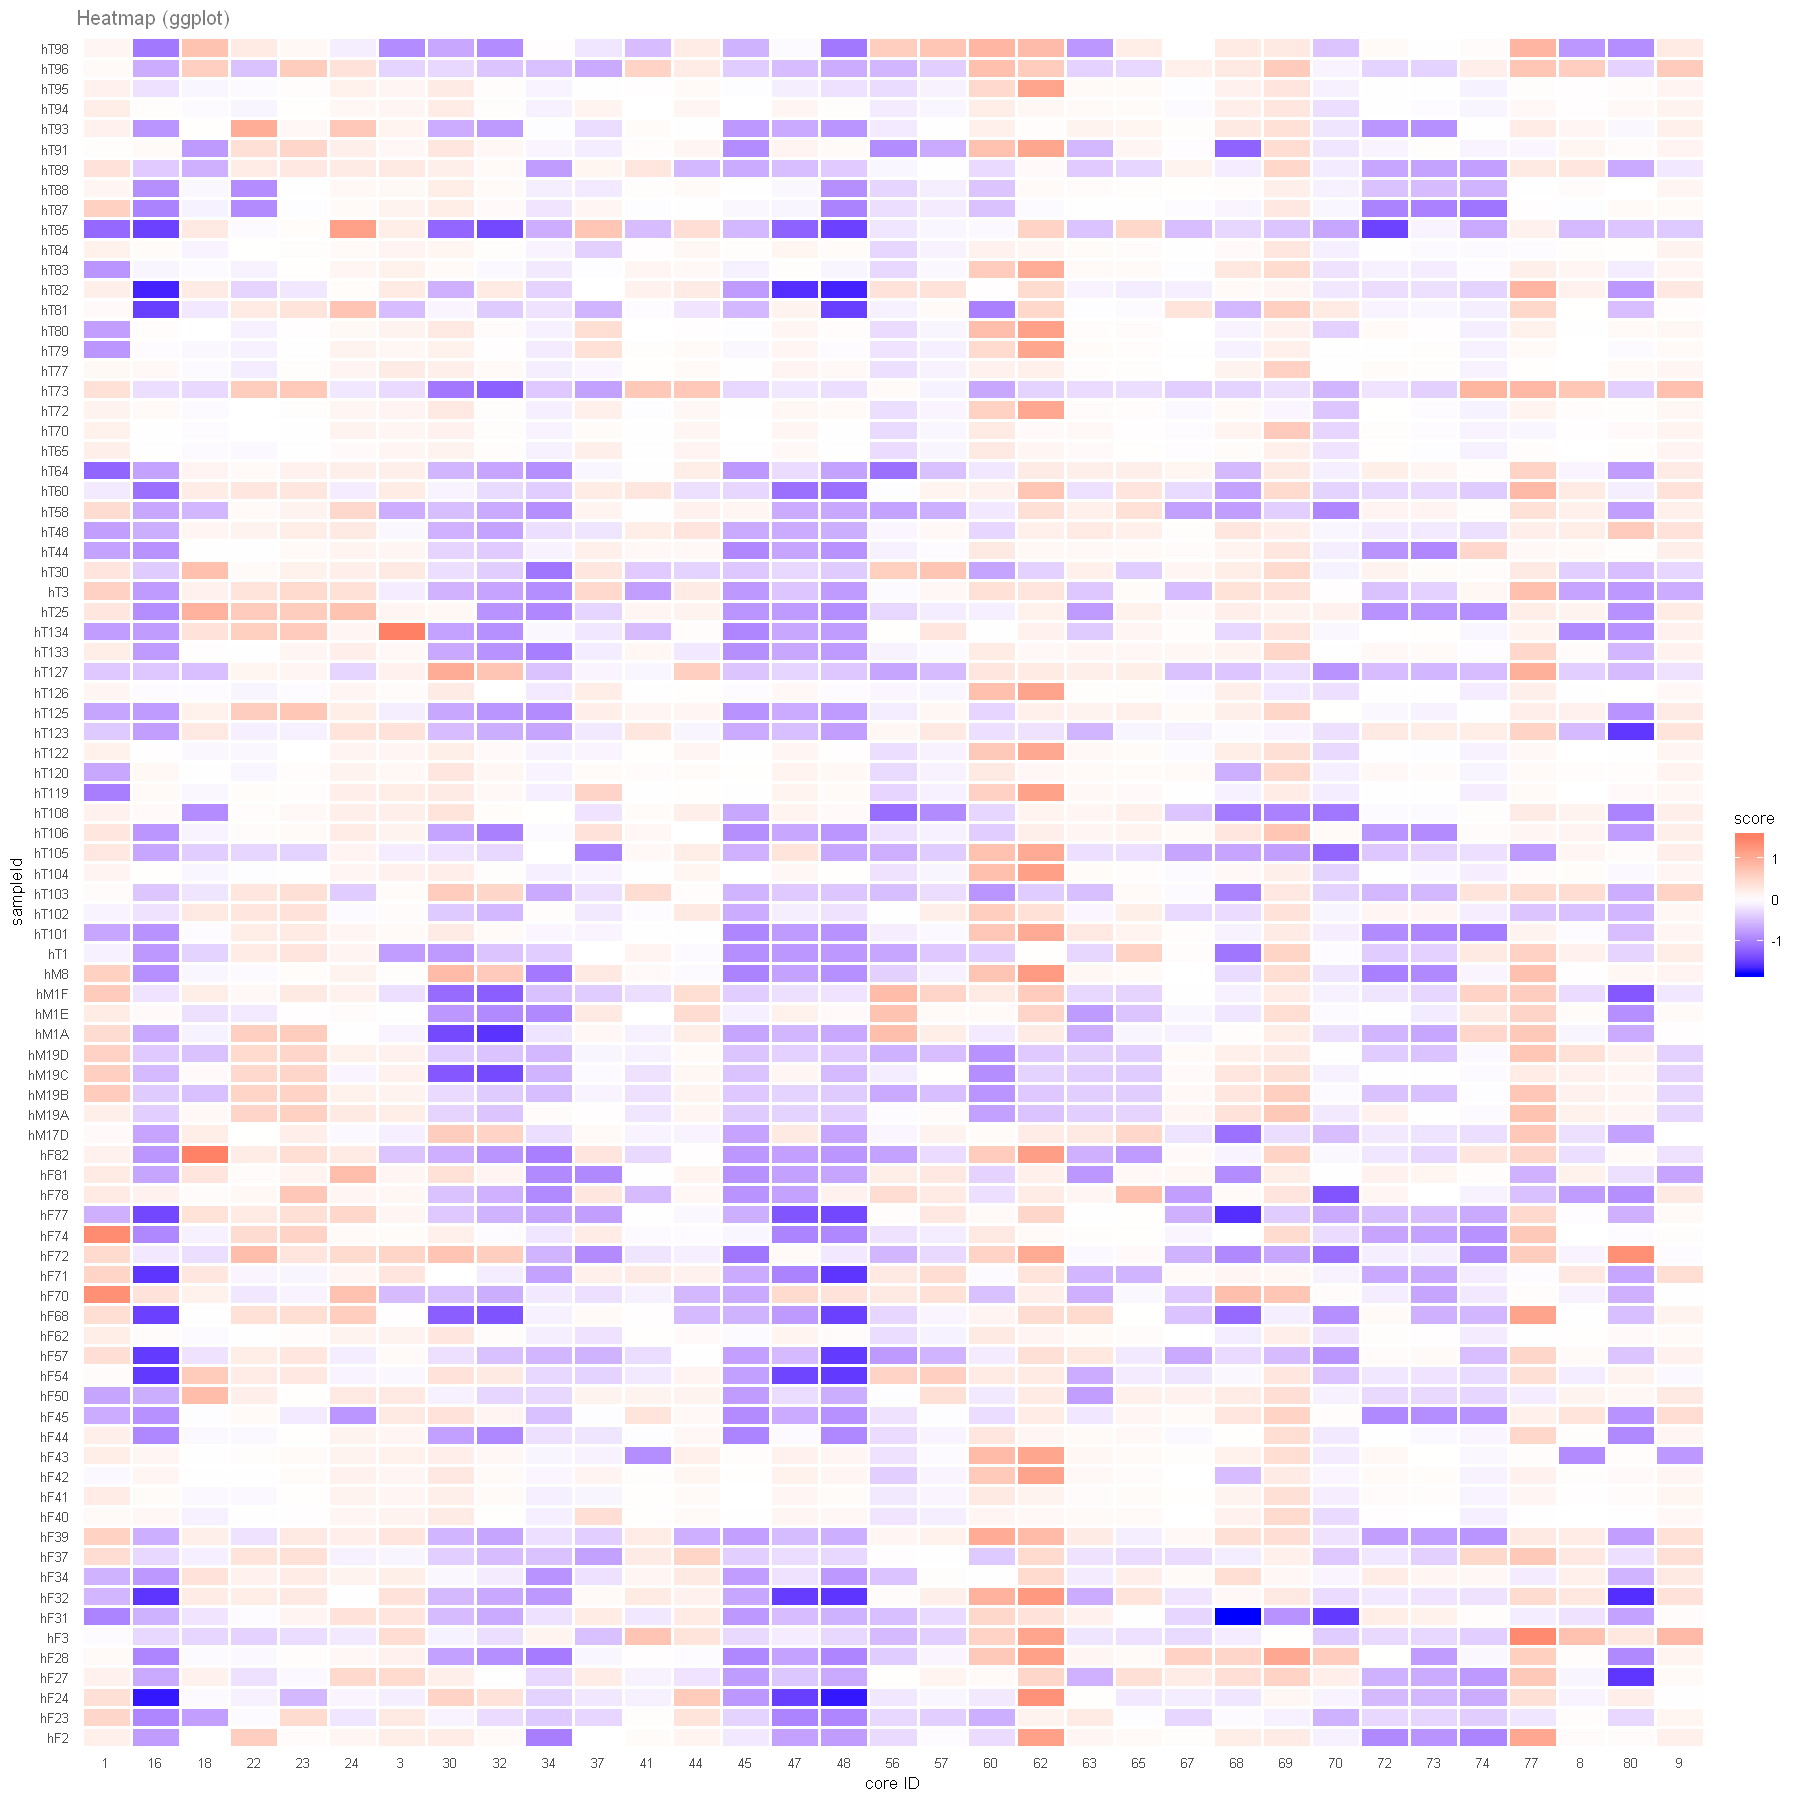

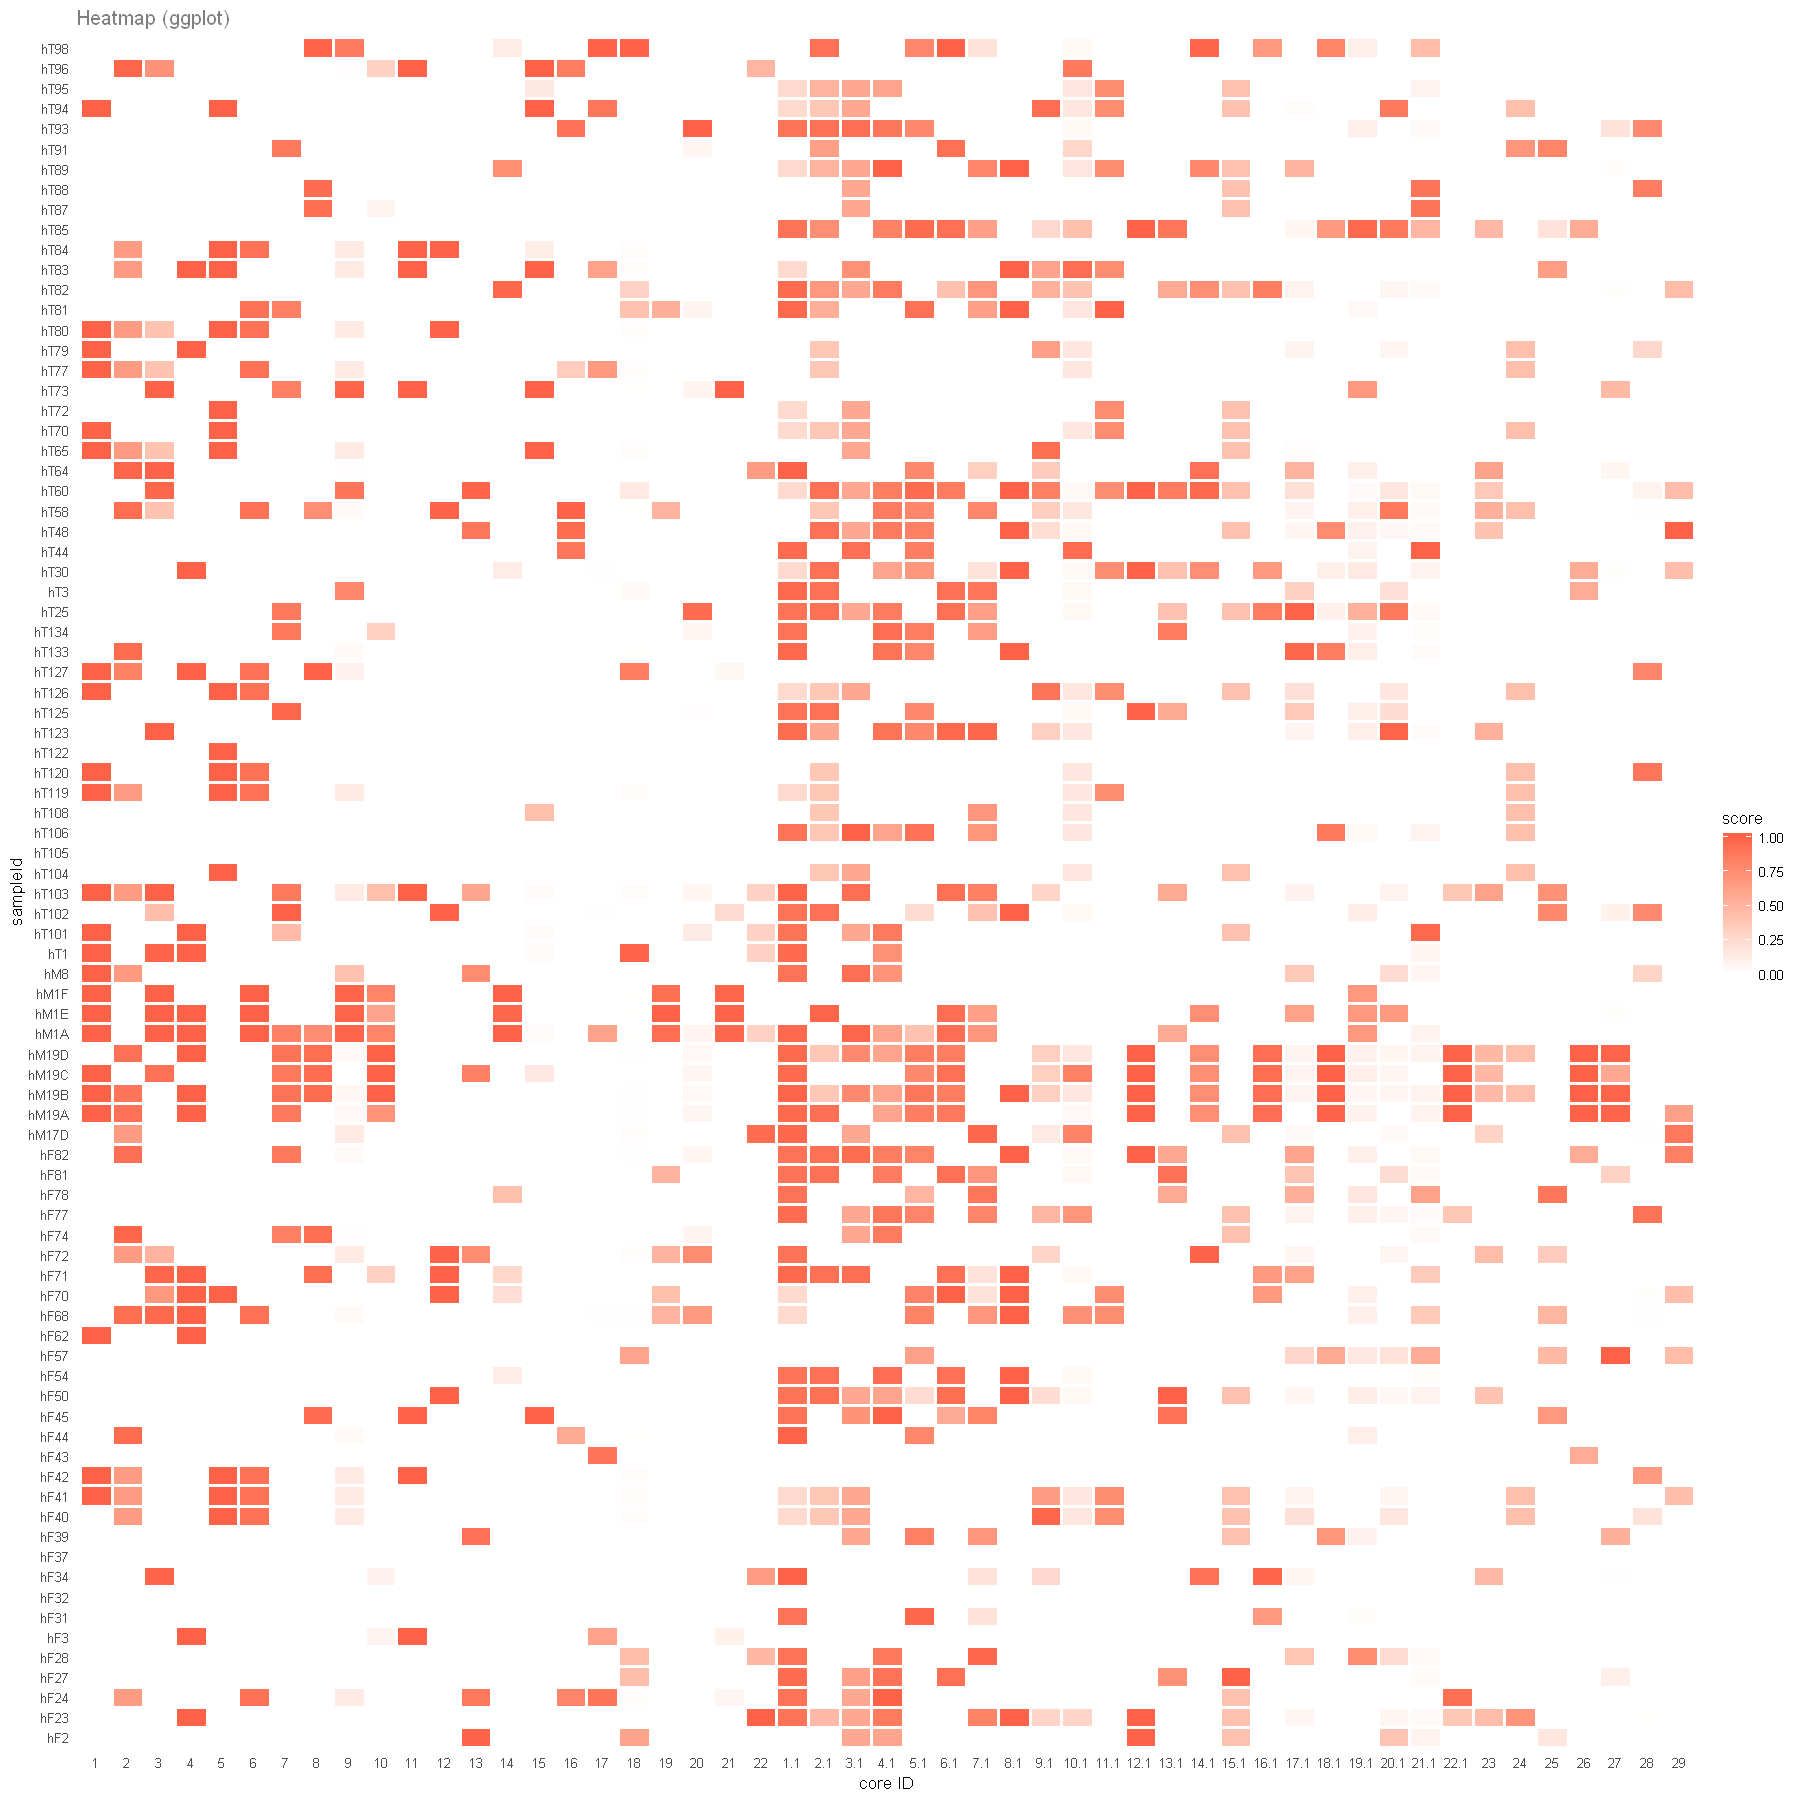

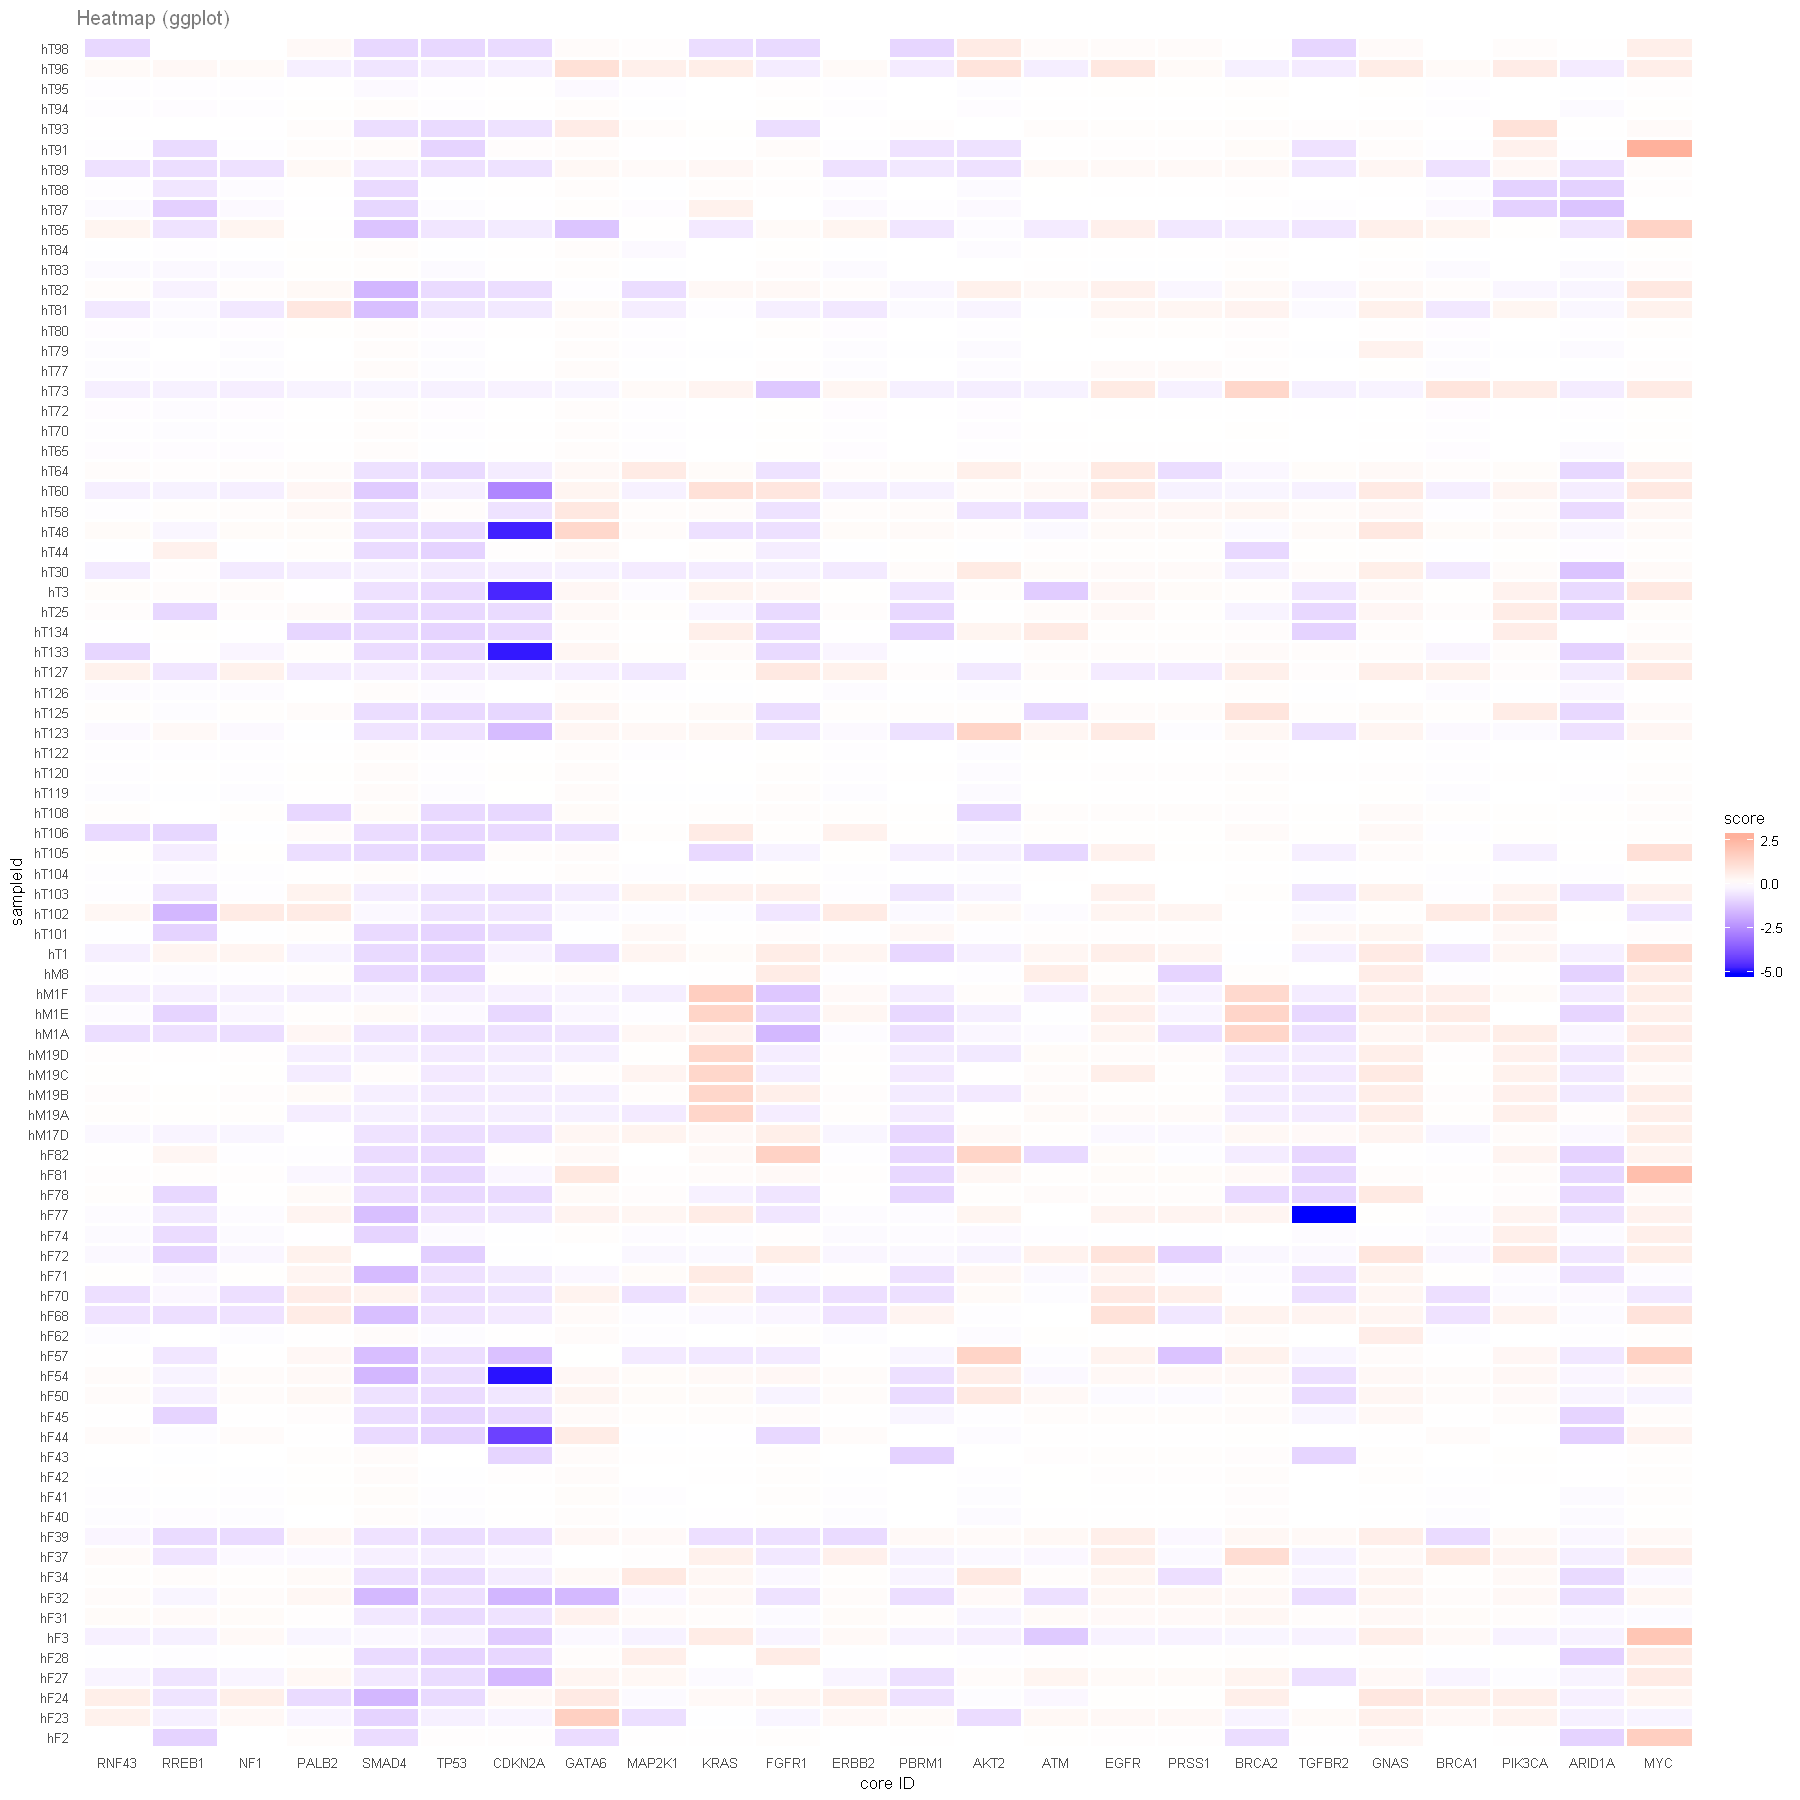

In [10]:
options(repr.plot.width=15, repr.plot.height=15)
visualizeUnclusteredHeatmap(segment_training_set$melted)
visualizeUnclusteredHeatmap(slicing_training_set$melted)
visualizeUnclusteredHeatmap(gene_training_set$melted)

In [51]:
head(segment_training_set$melted)

,score,featureId,sampleId
1,0.18310037,1,hF2
3,0.20891867,3,hF2
8,0.04517097,8,hF2
9,0.18194512,9,hF2
16,-0.76660719,16,hF2
18,0.00189109,18,hF2


### Visualize the dendroheatmap of the clustered scores for all COREs

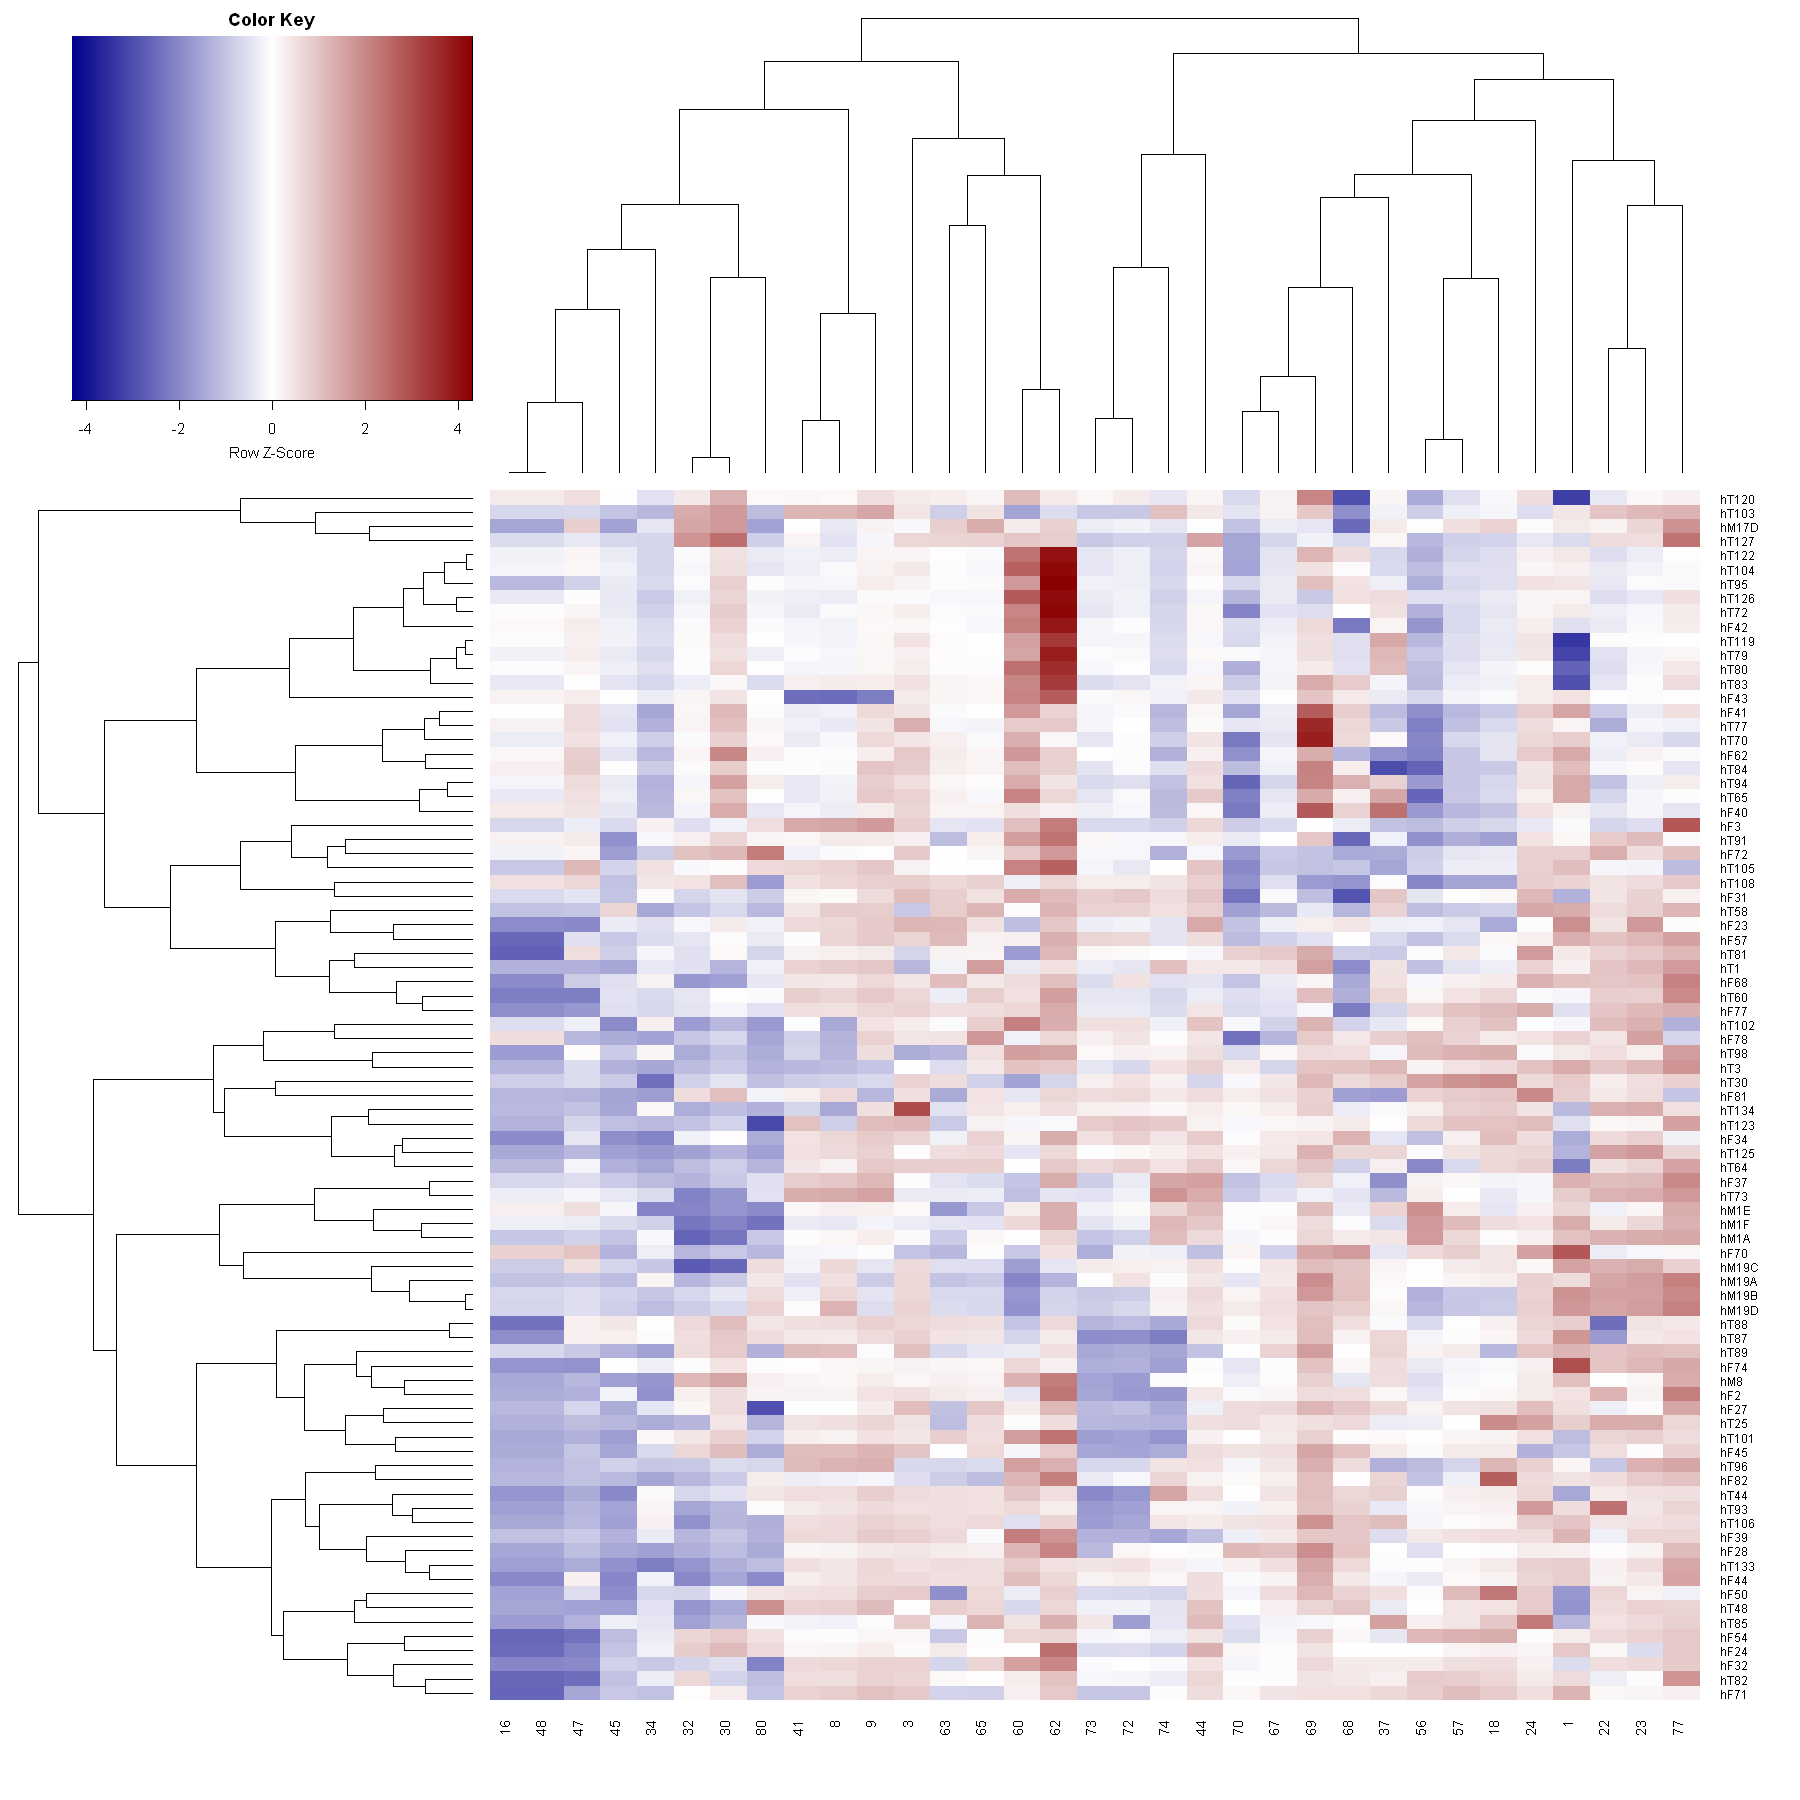

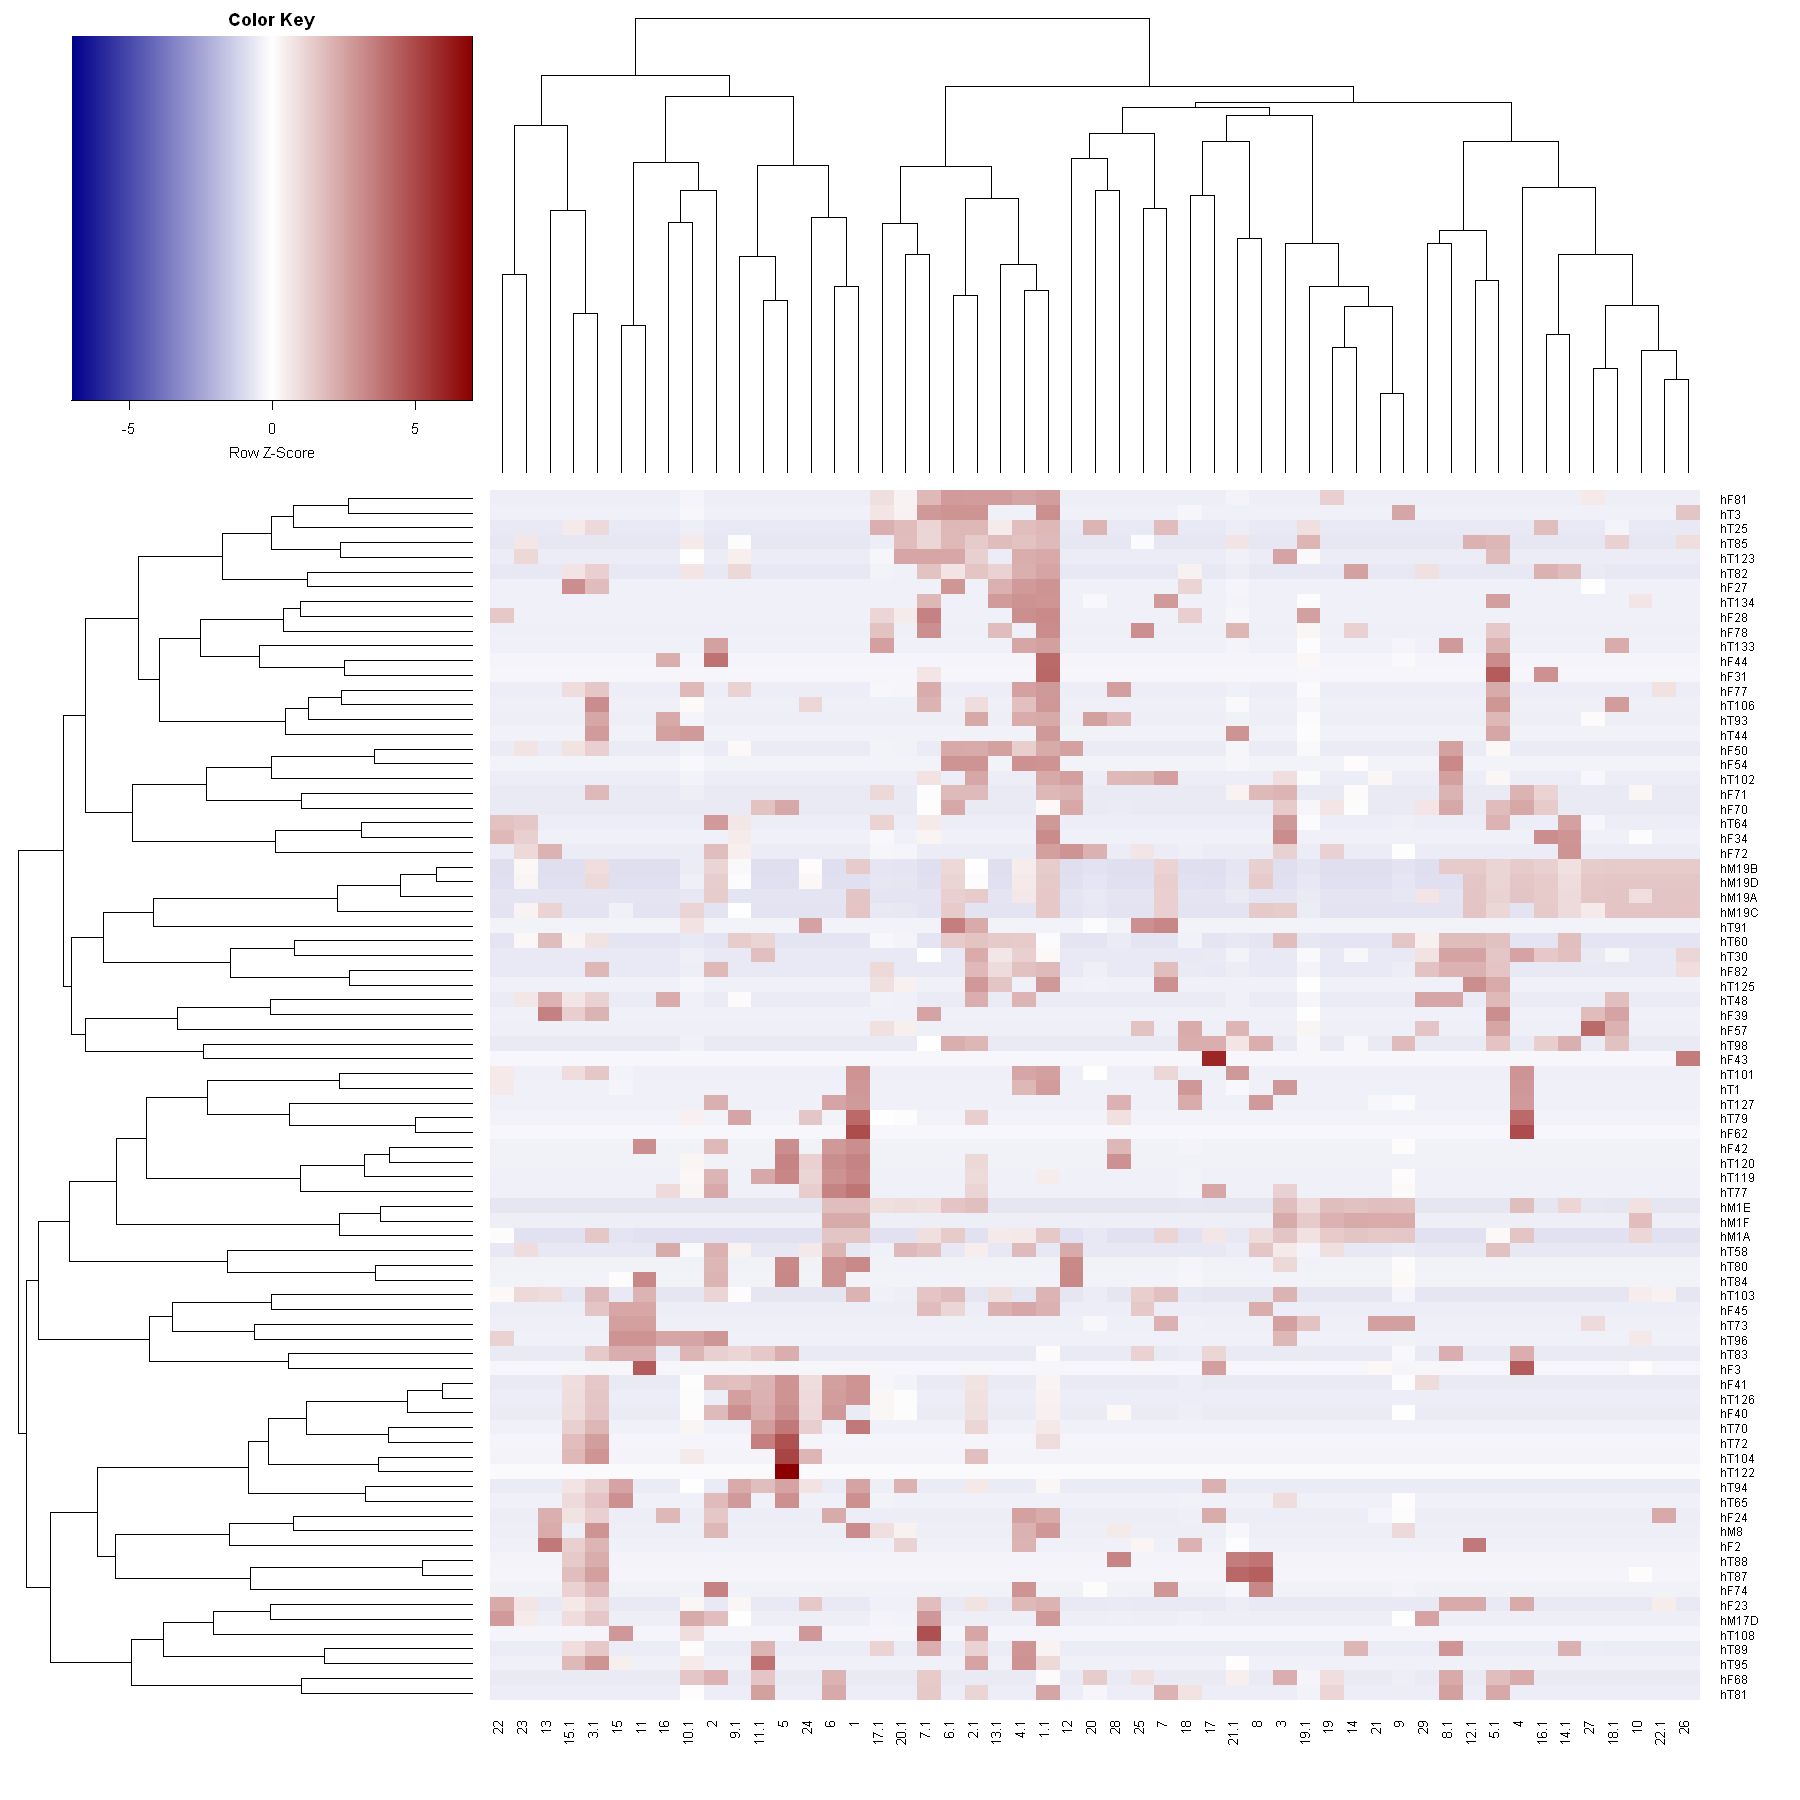

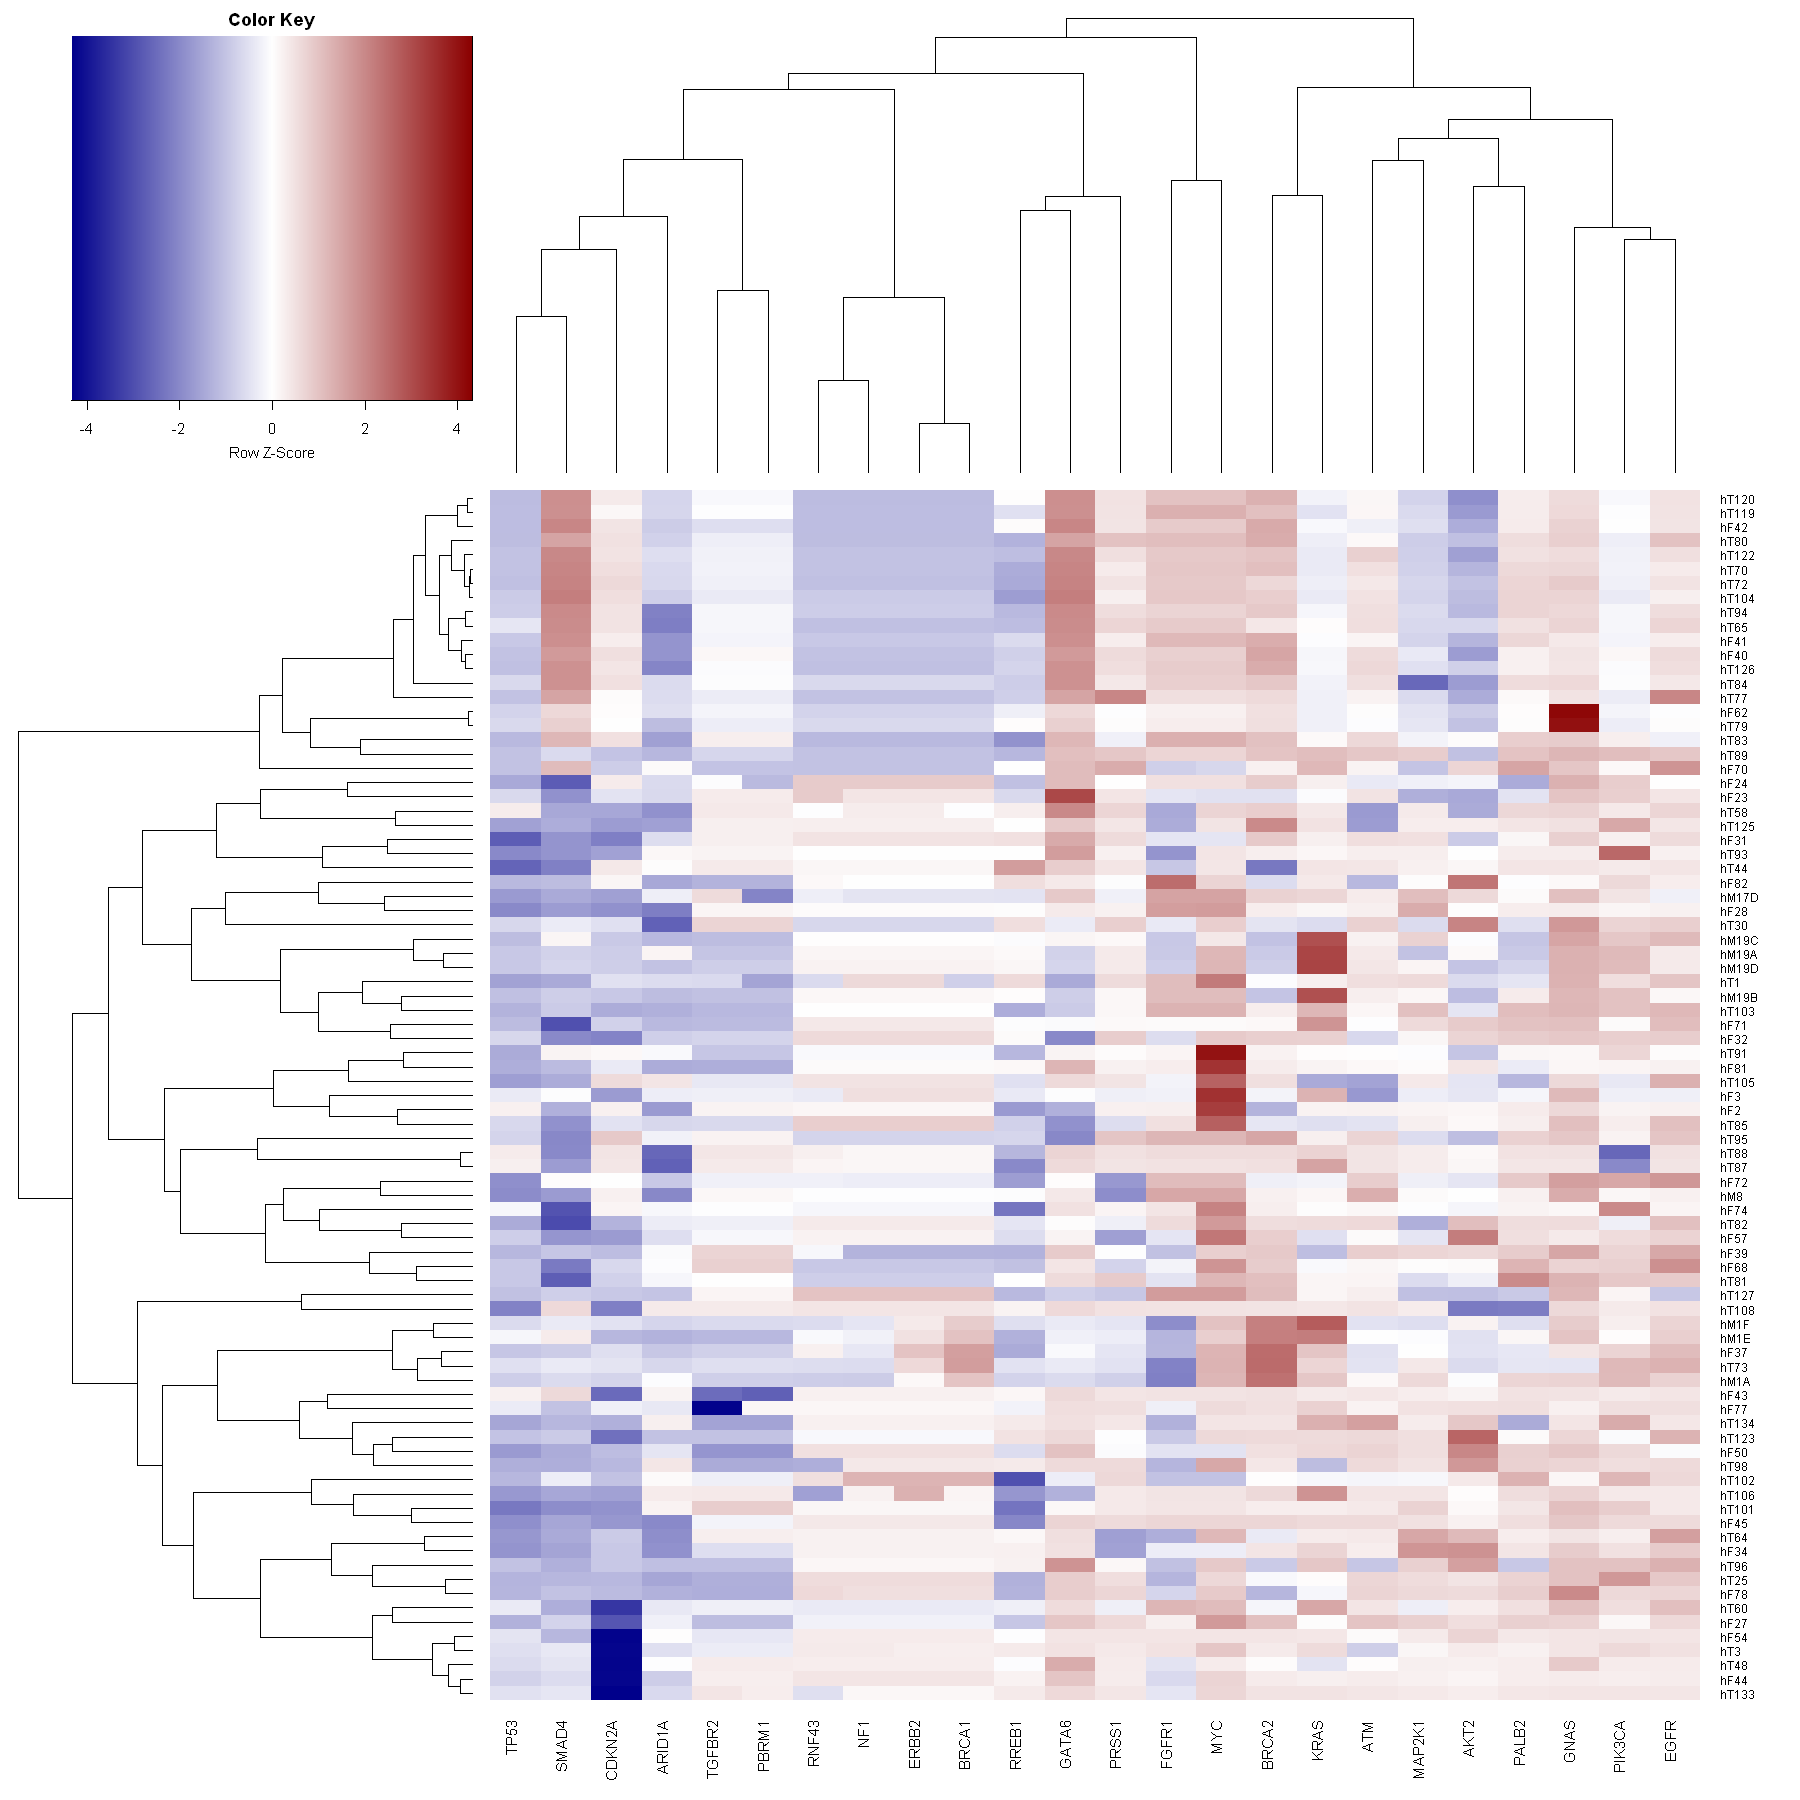

In [11]:
options(repr.plot.width=15, repr.plot.height=15)
hc_segment <- clusterTrainingSet(segment_training_set$melted, visualize = TRUE)
hc_slicing <- clusterTrainingSet(slicing_training_set$melted, visualize = TRUE)
hc_gene <- clusterTrainingSet(gene_training_set$melted, visualize = TRUE)

### Visualize the dendrogram of the clustered organoids based on CORE scores

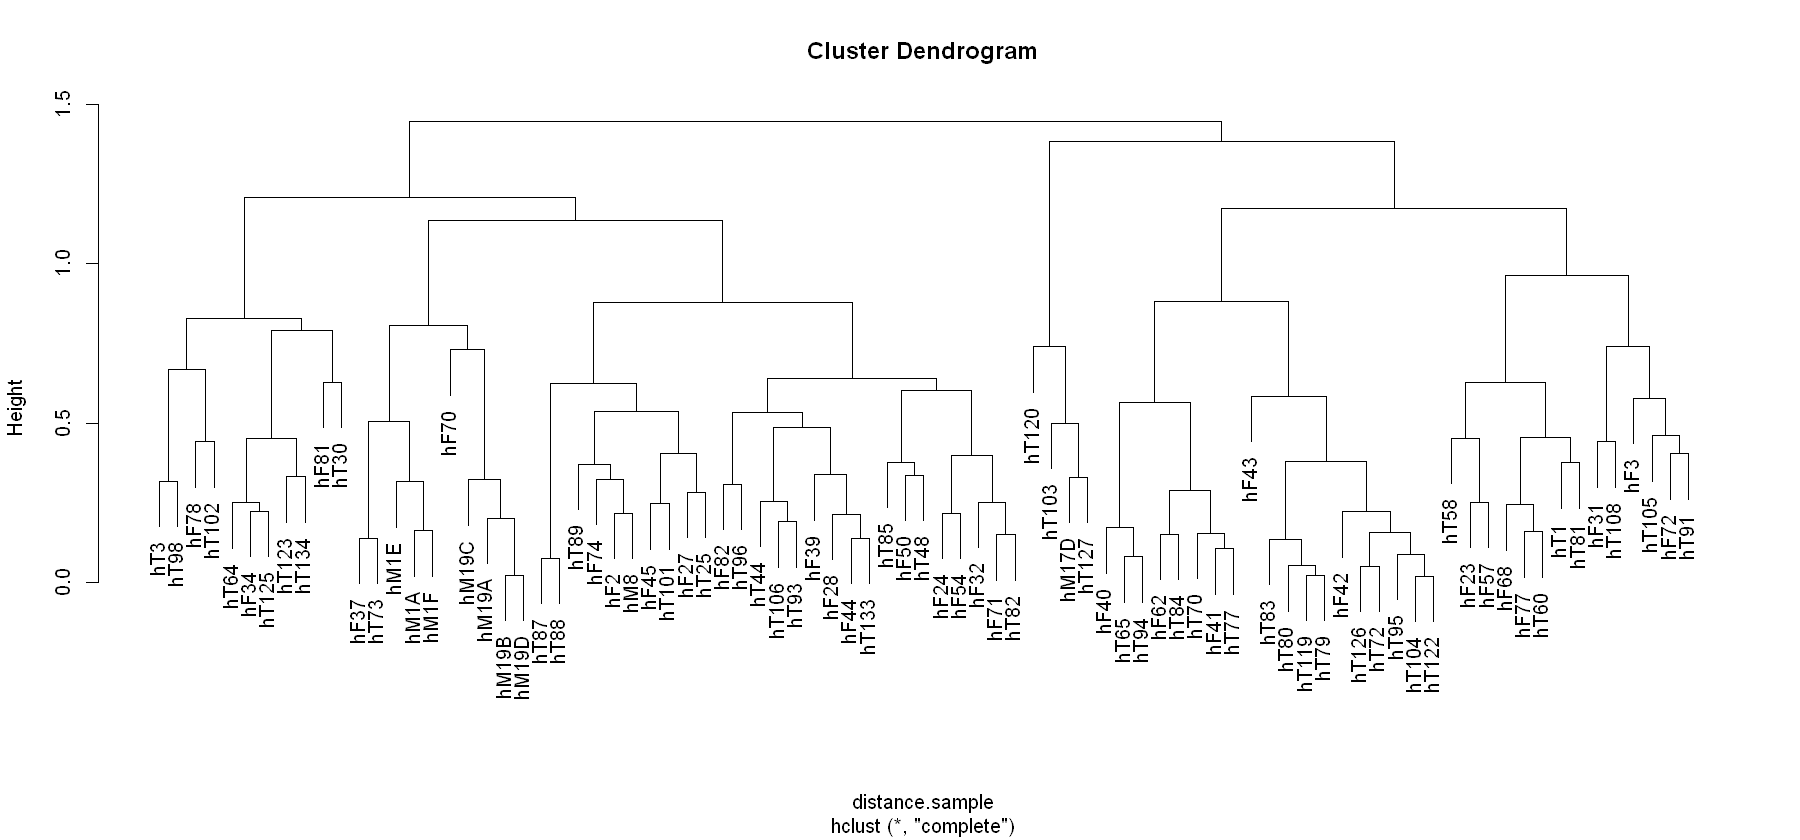

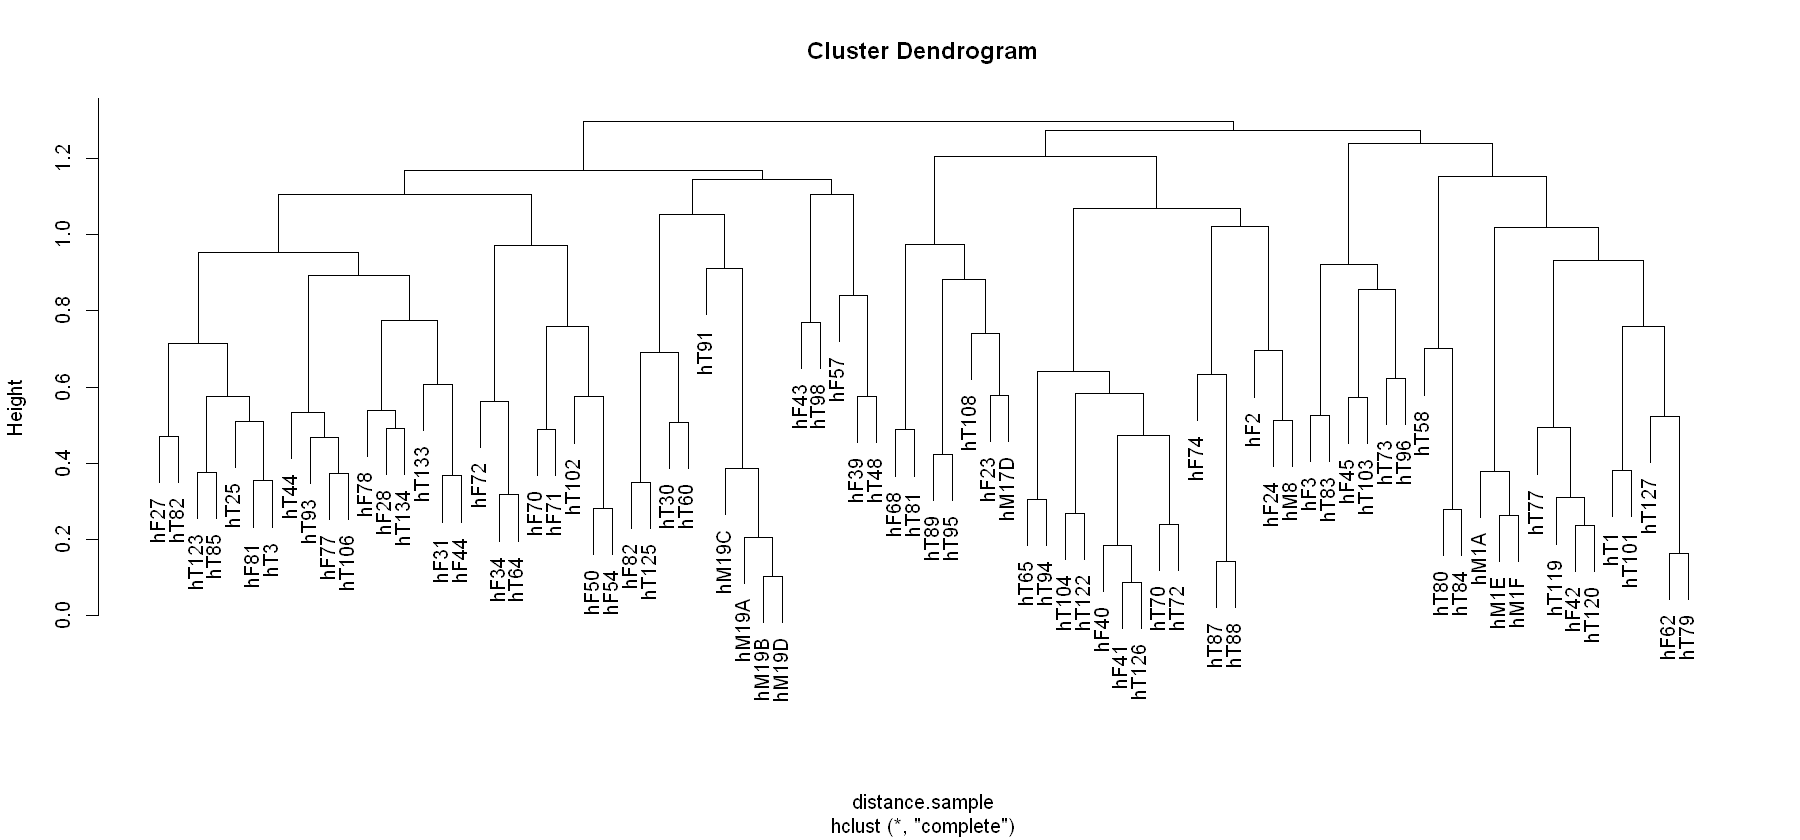

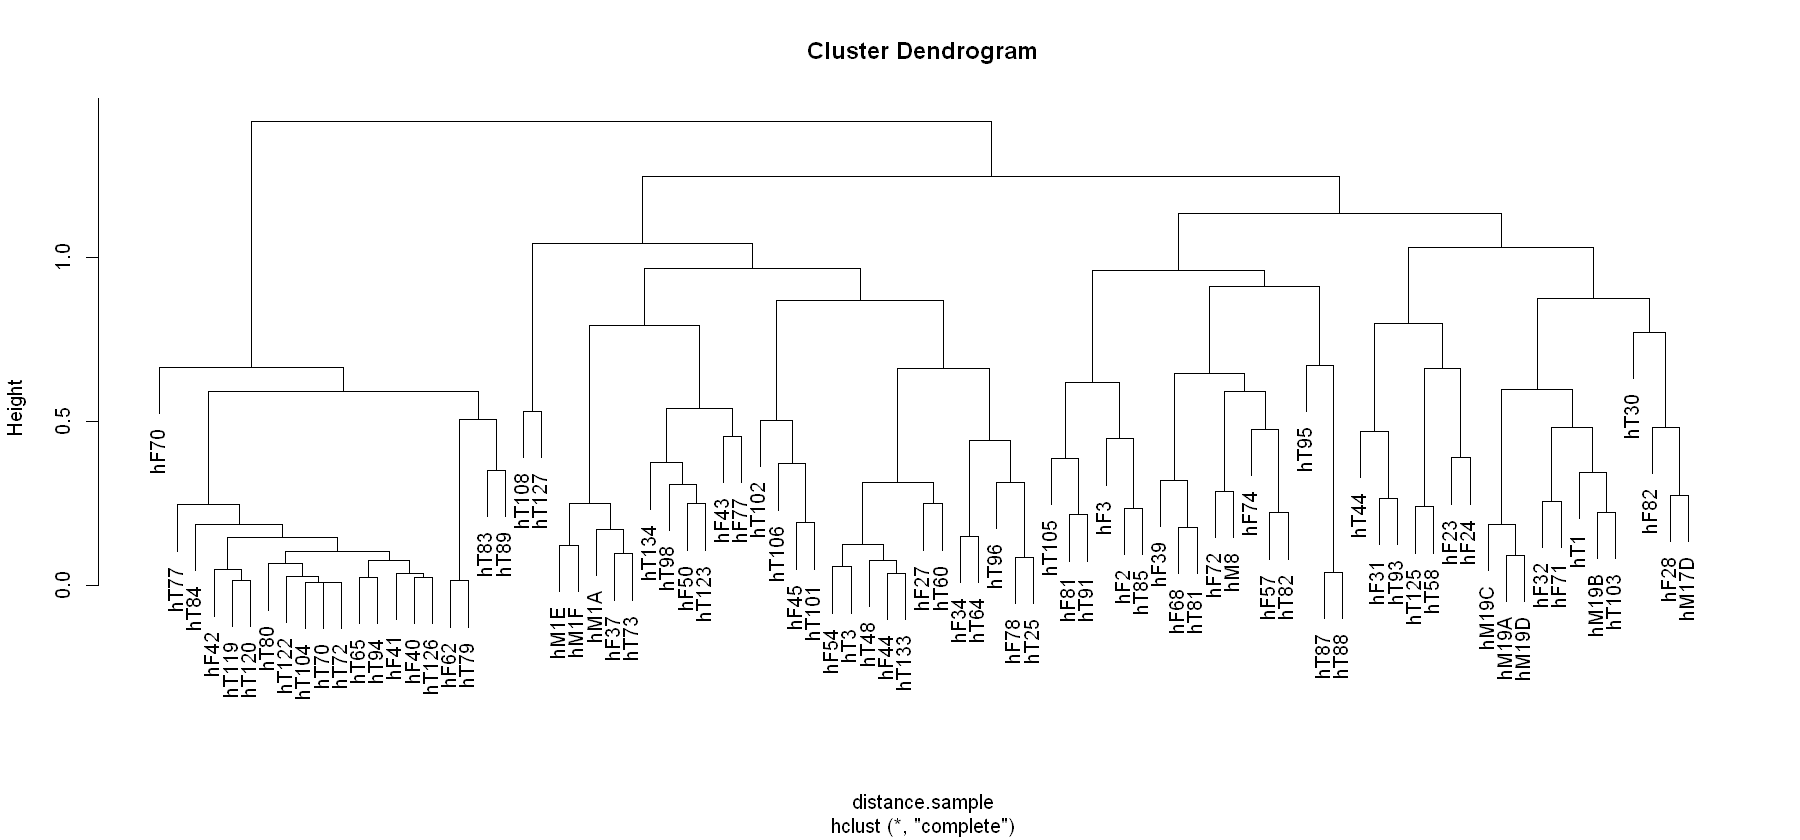

In [12]:
options(repr.plot.width=15, repr.plot.height=7)
plot(hc_segment)
plot(hc_slicing)
plot(hc_gene)

### Visualize clustered dendroheatmap with labels

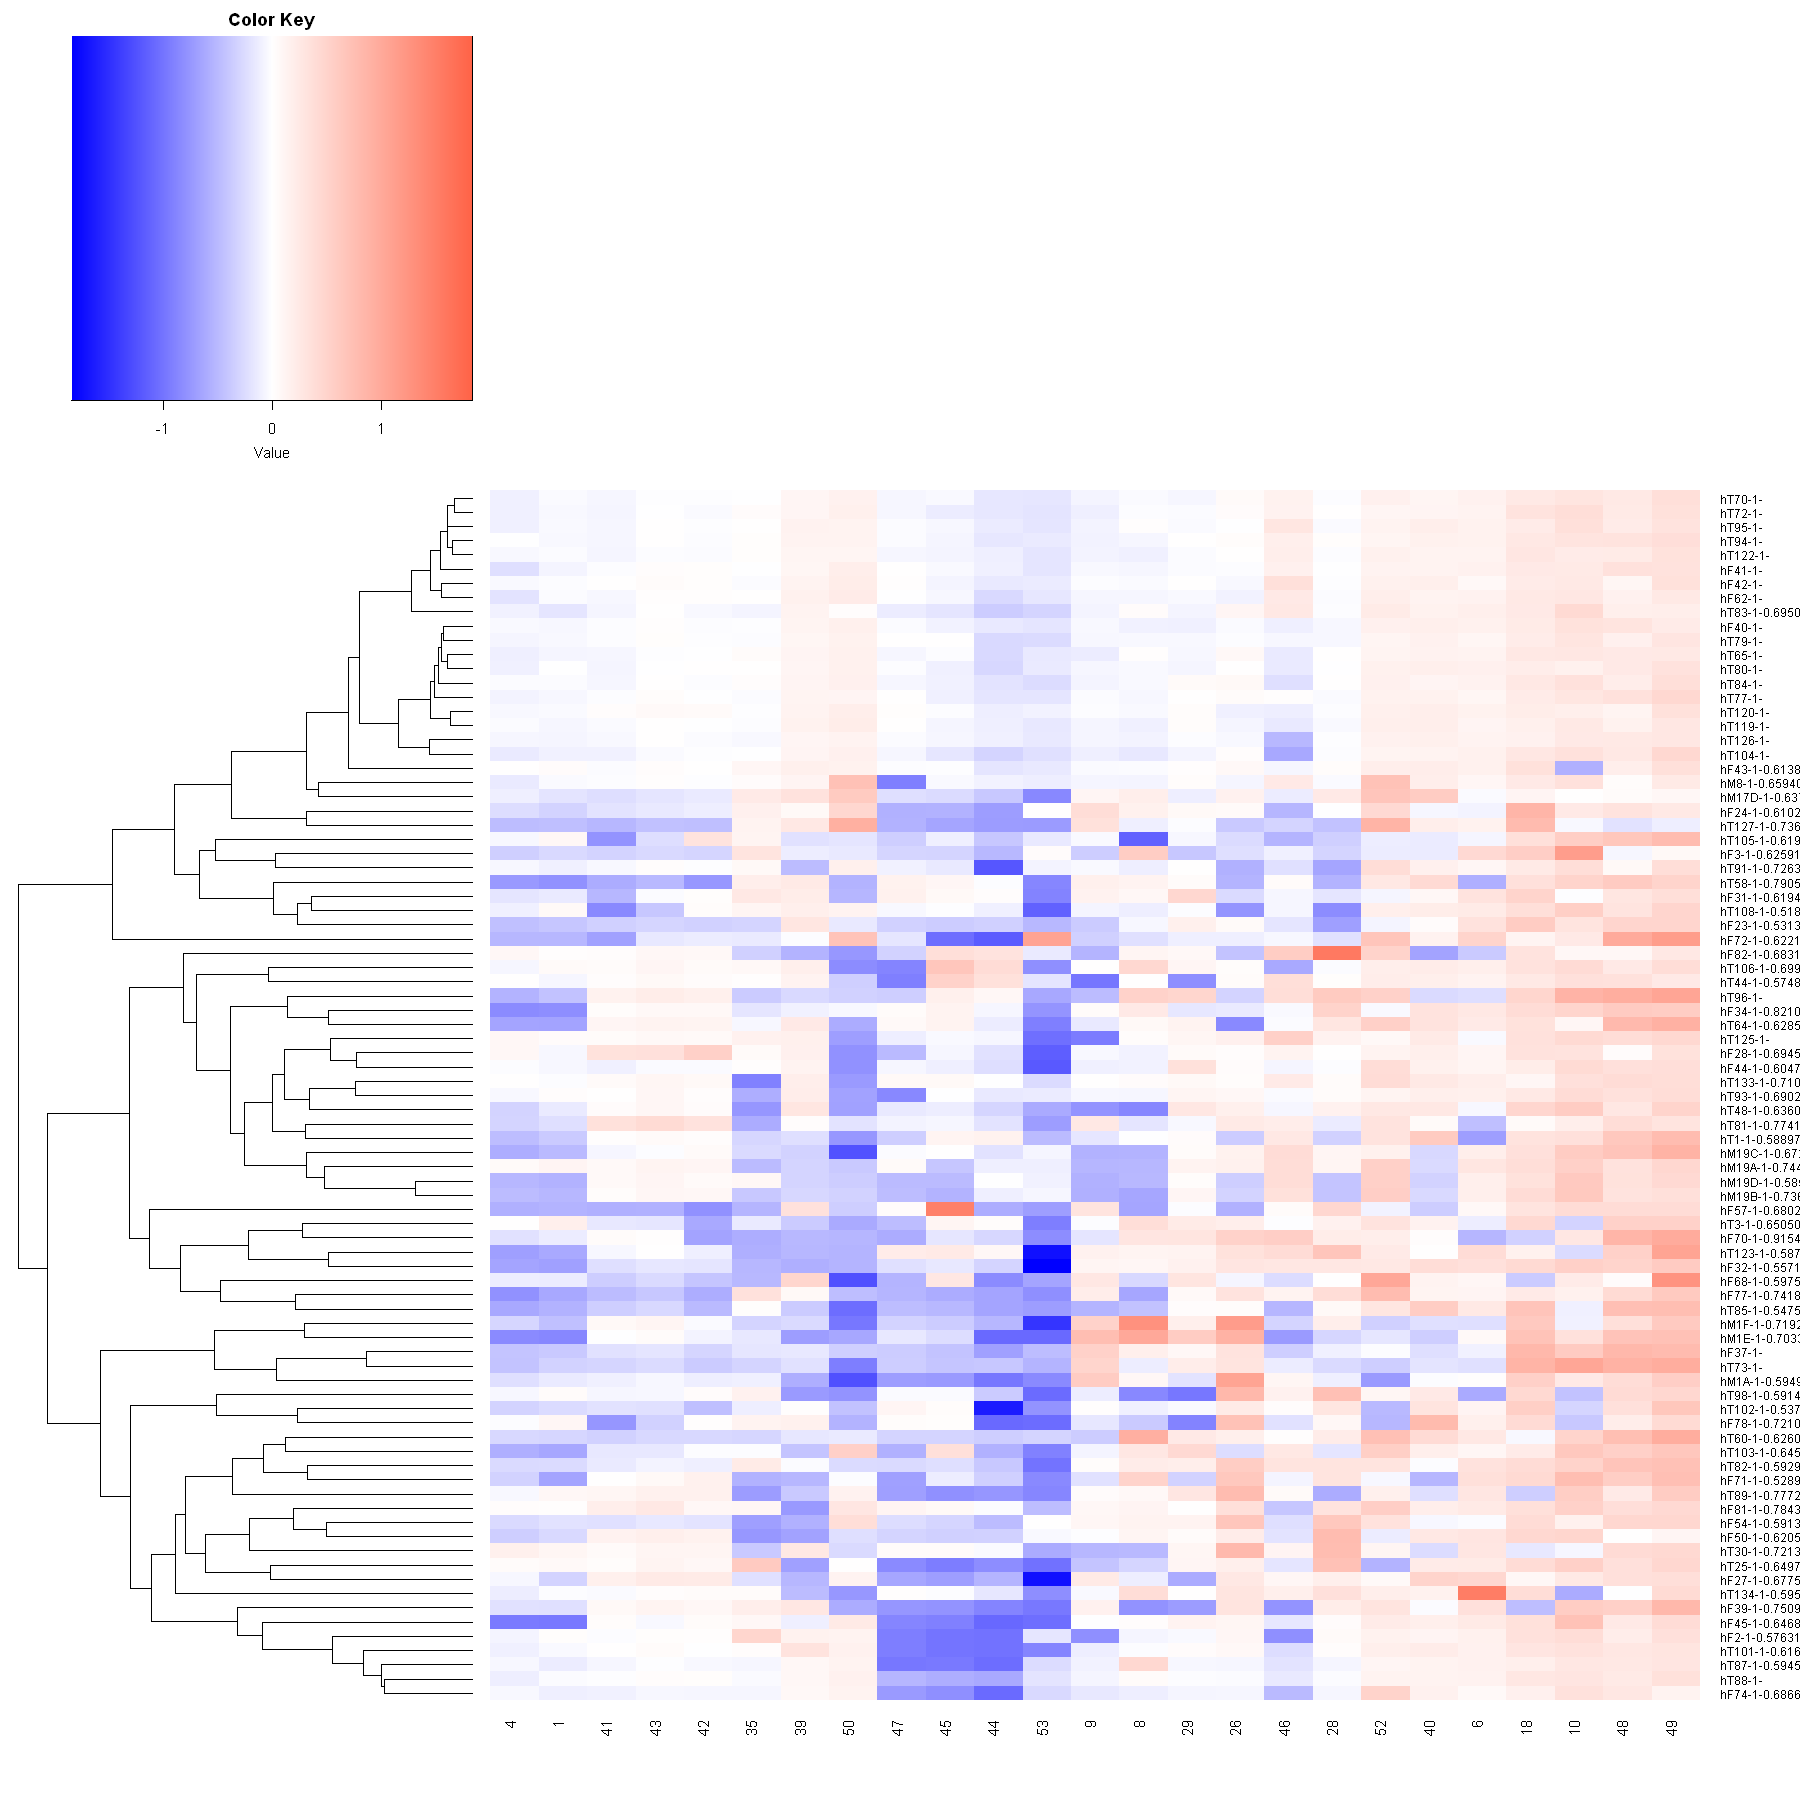

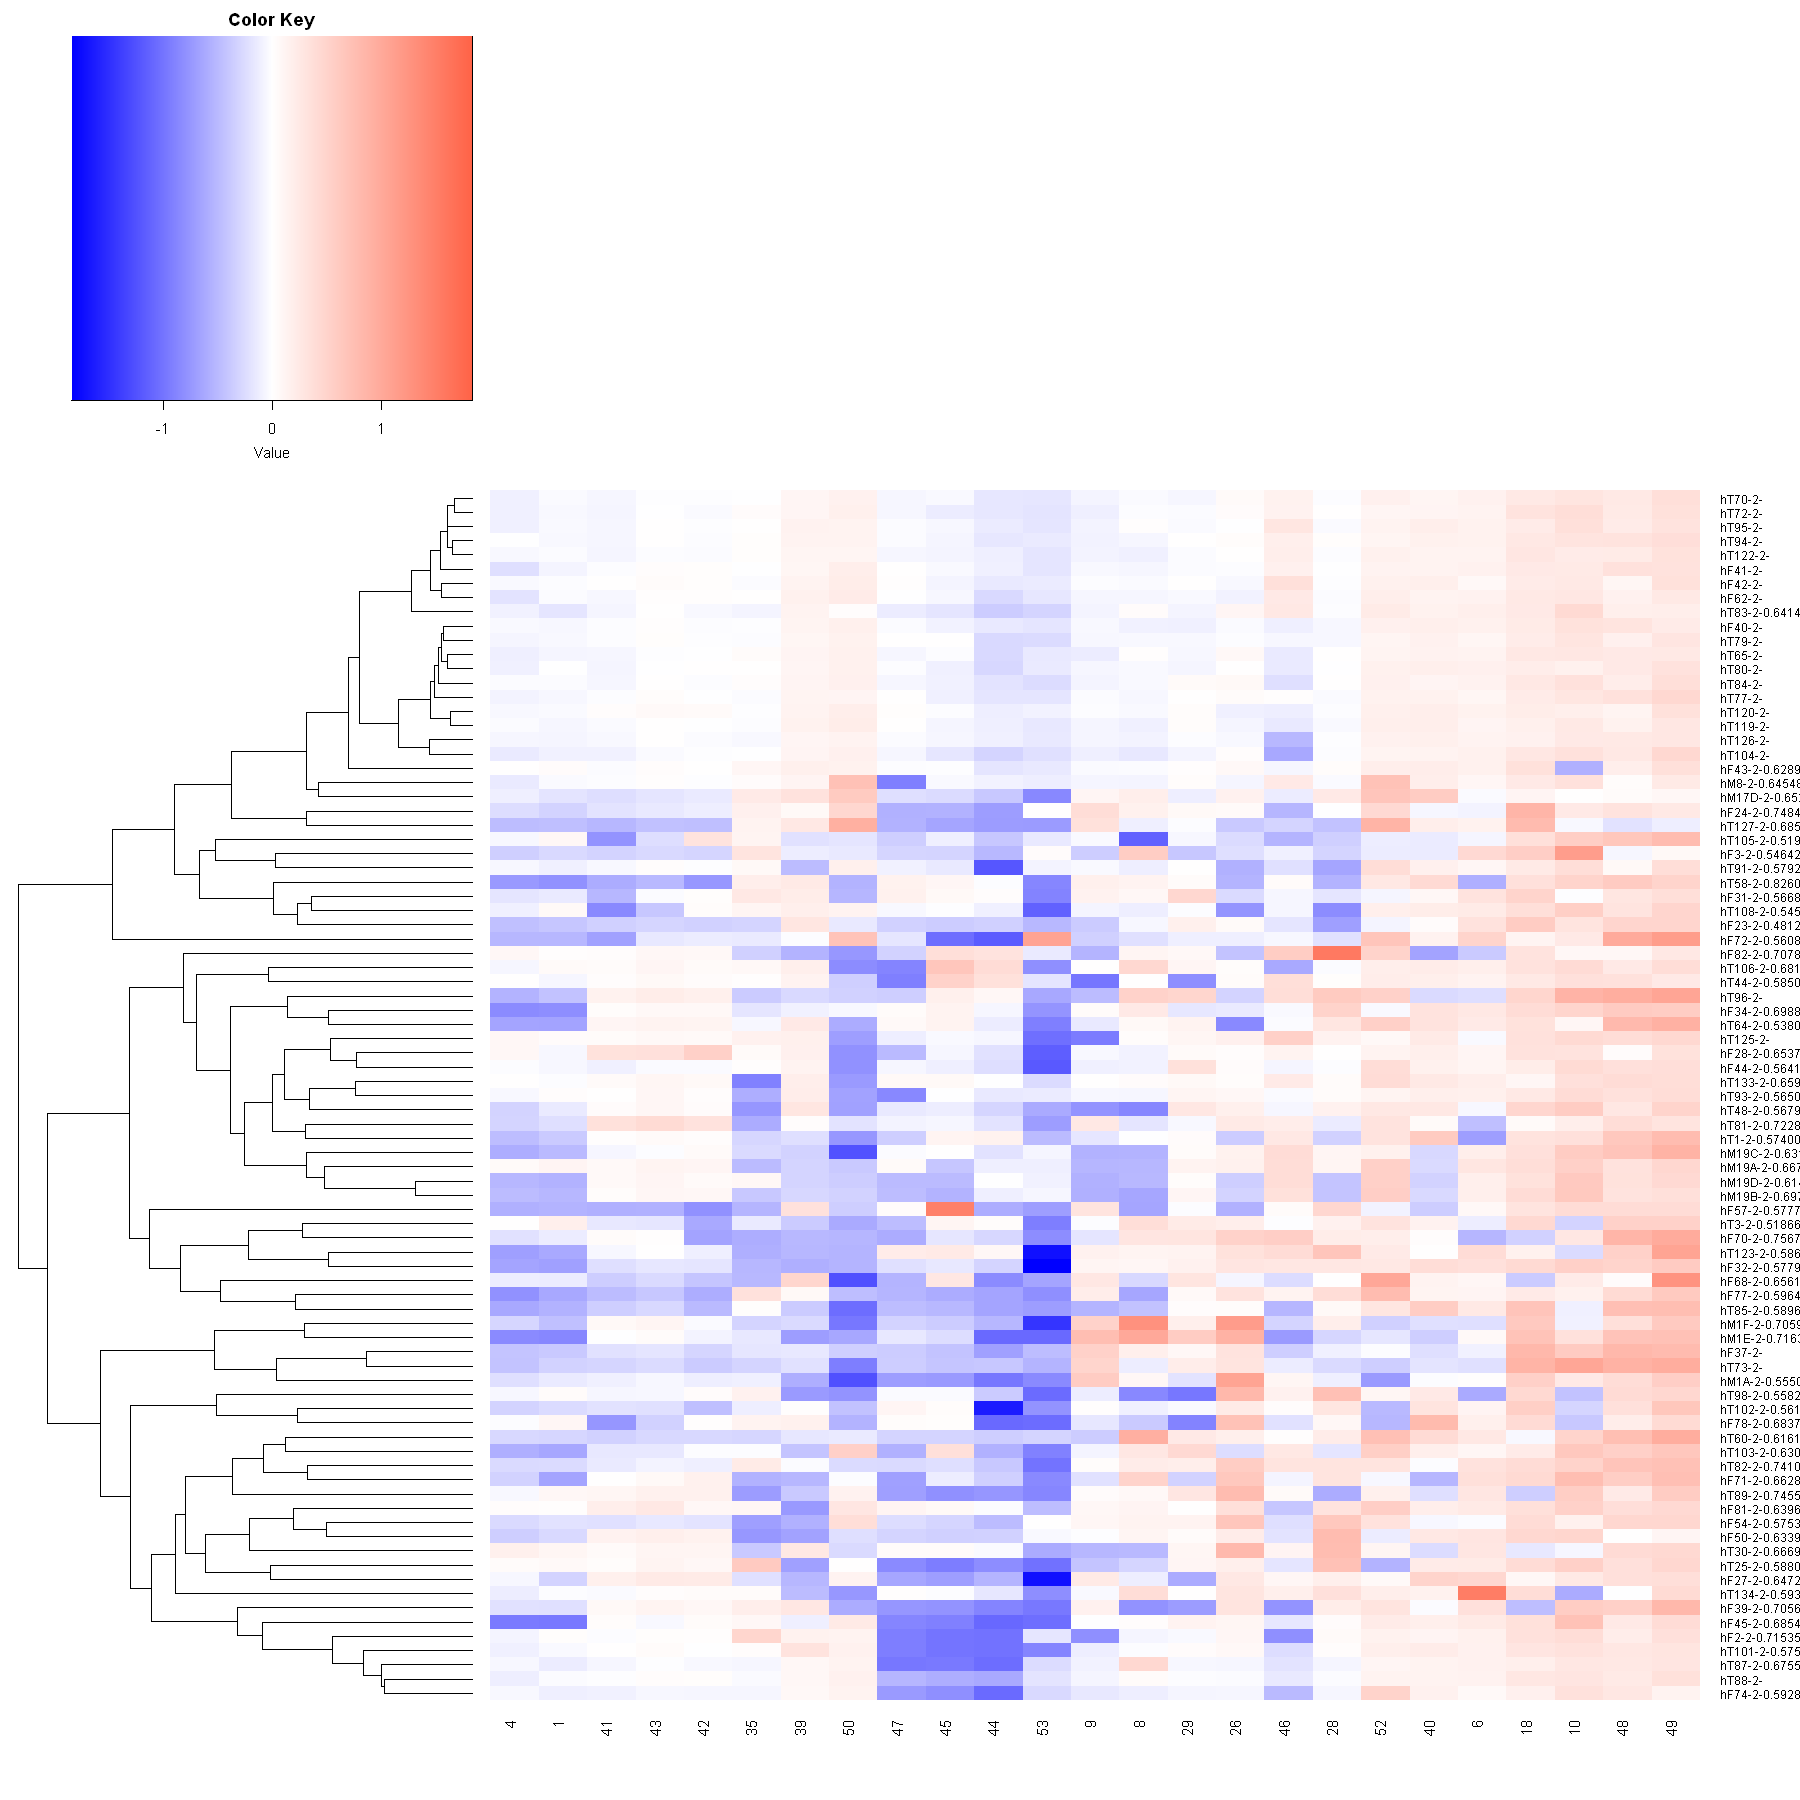

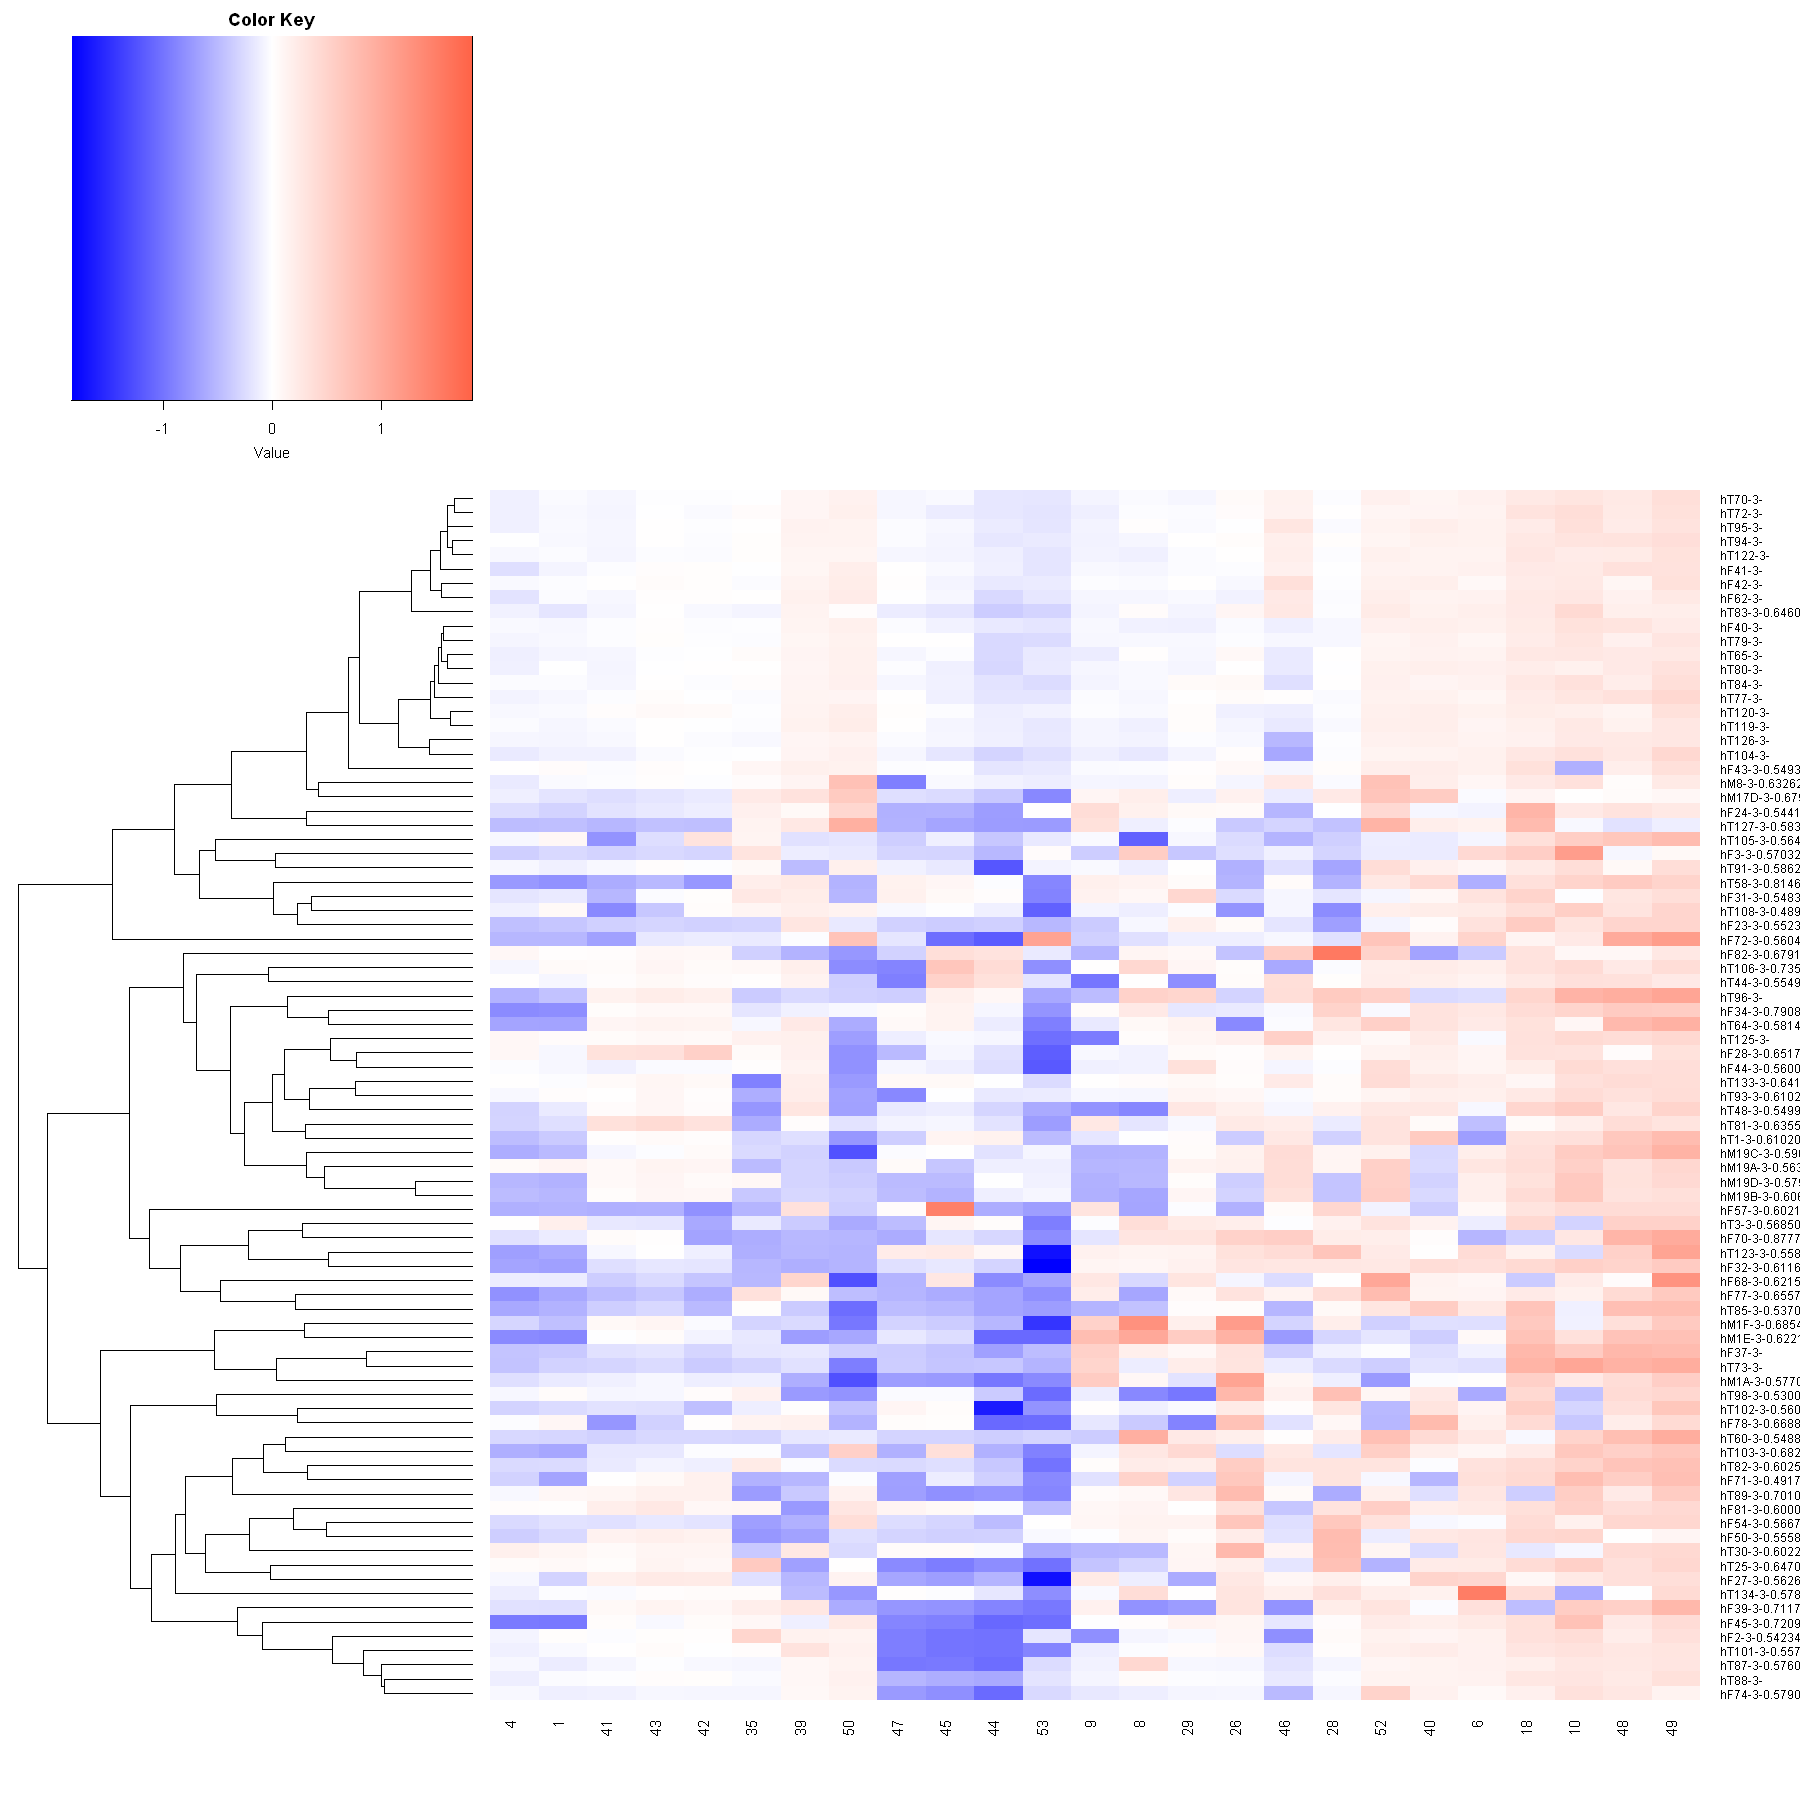

ERROR: Error in aucData[[label.i]]: subscript out of bounds


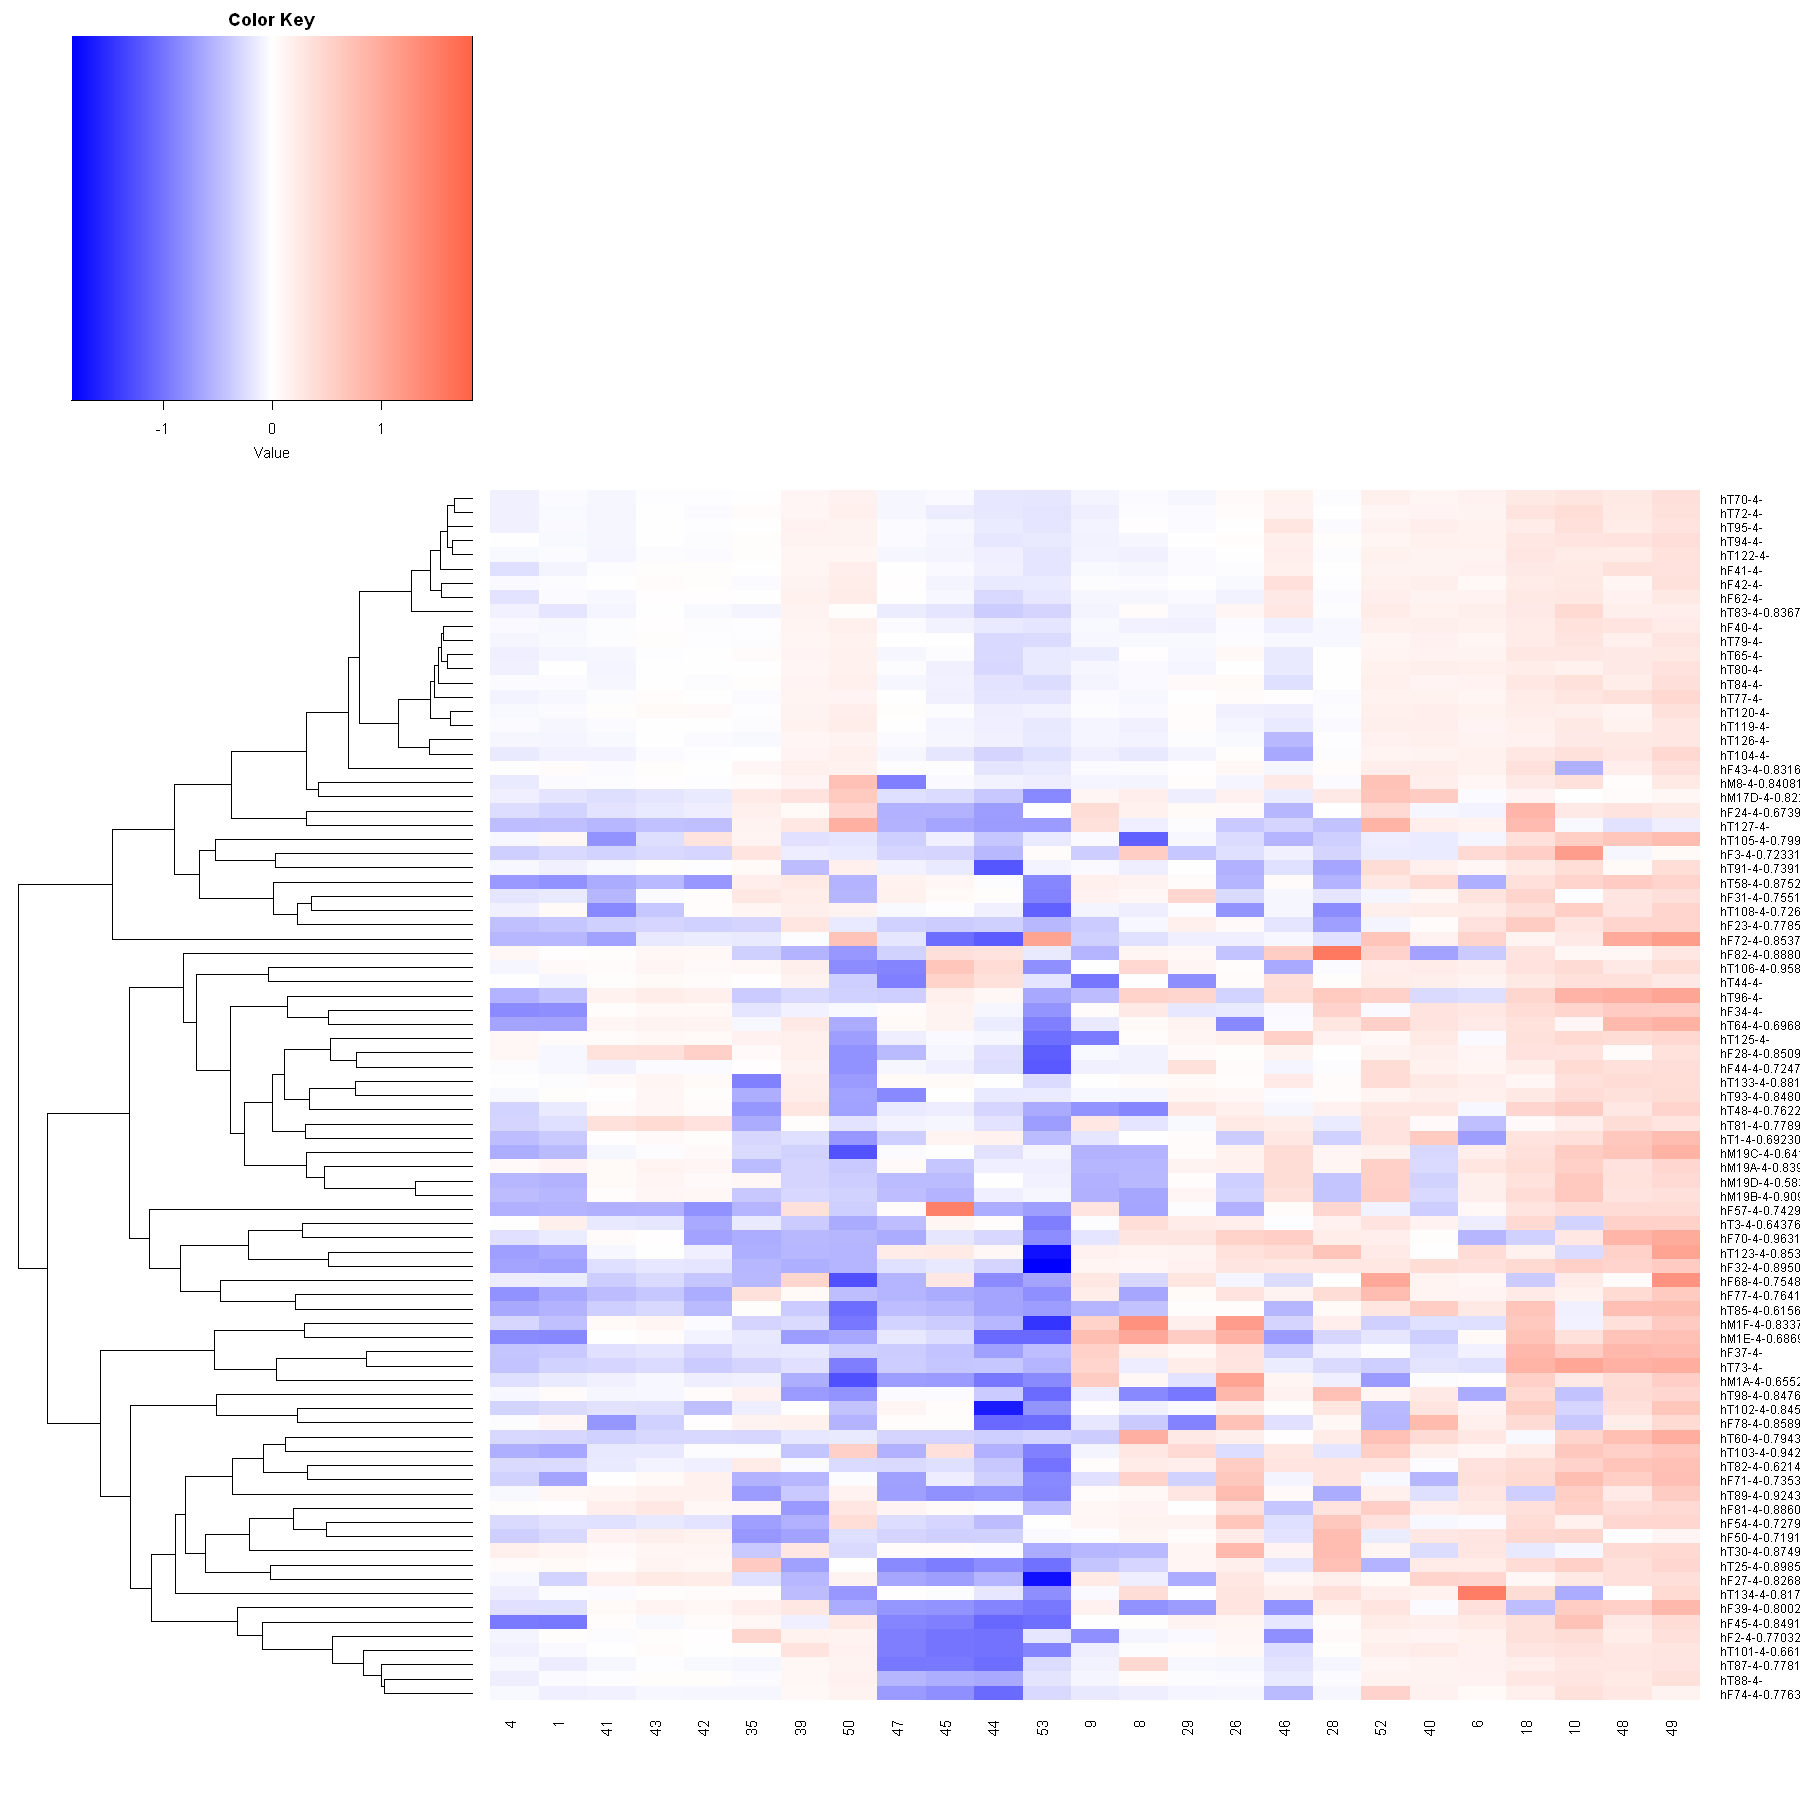

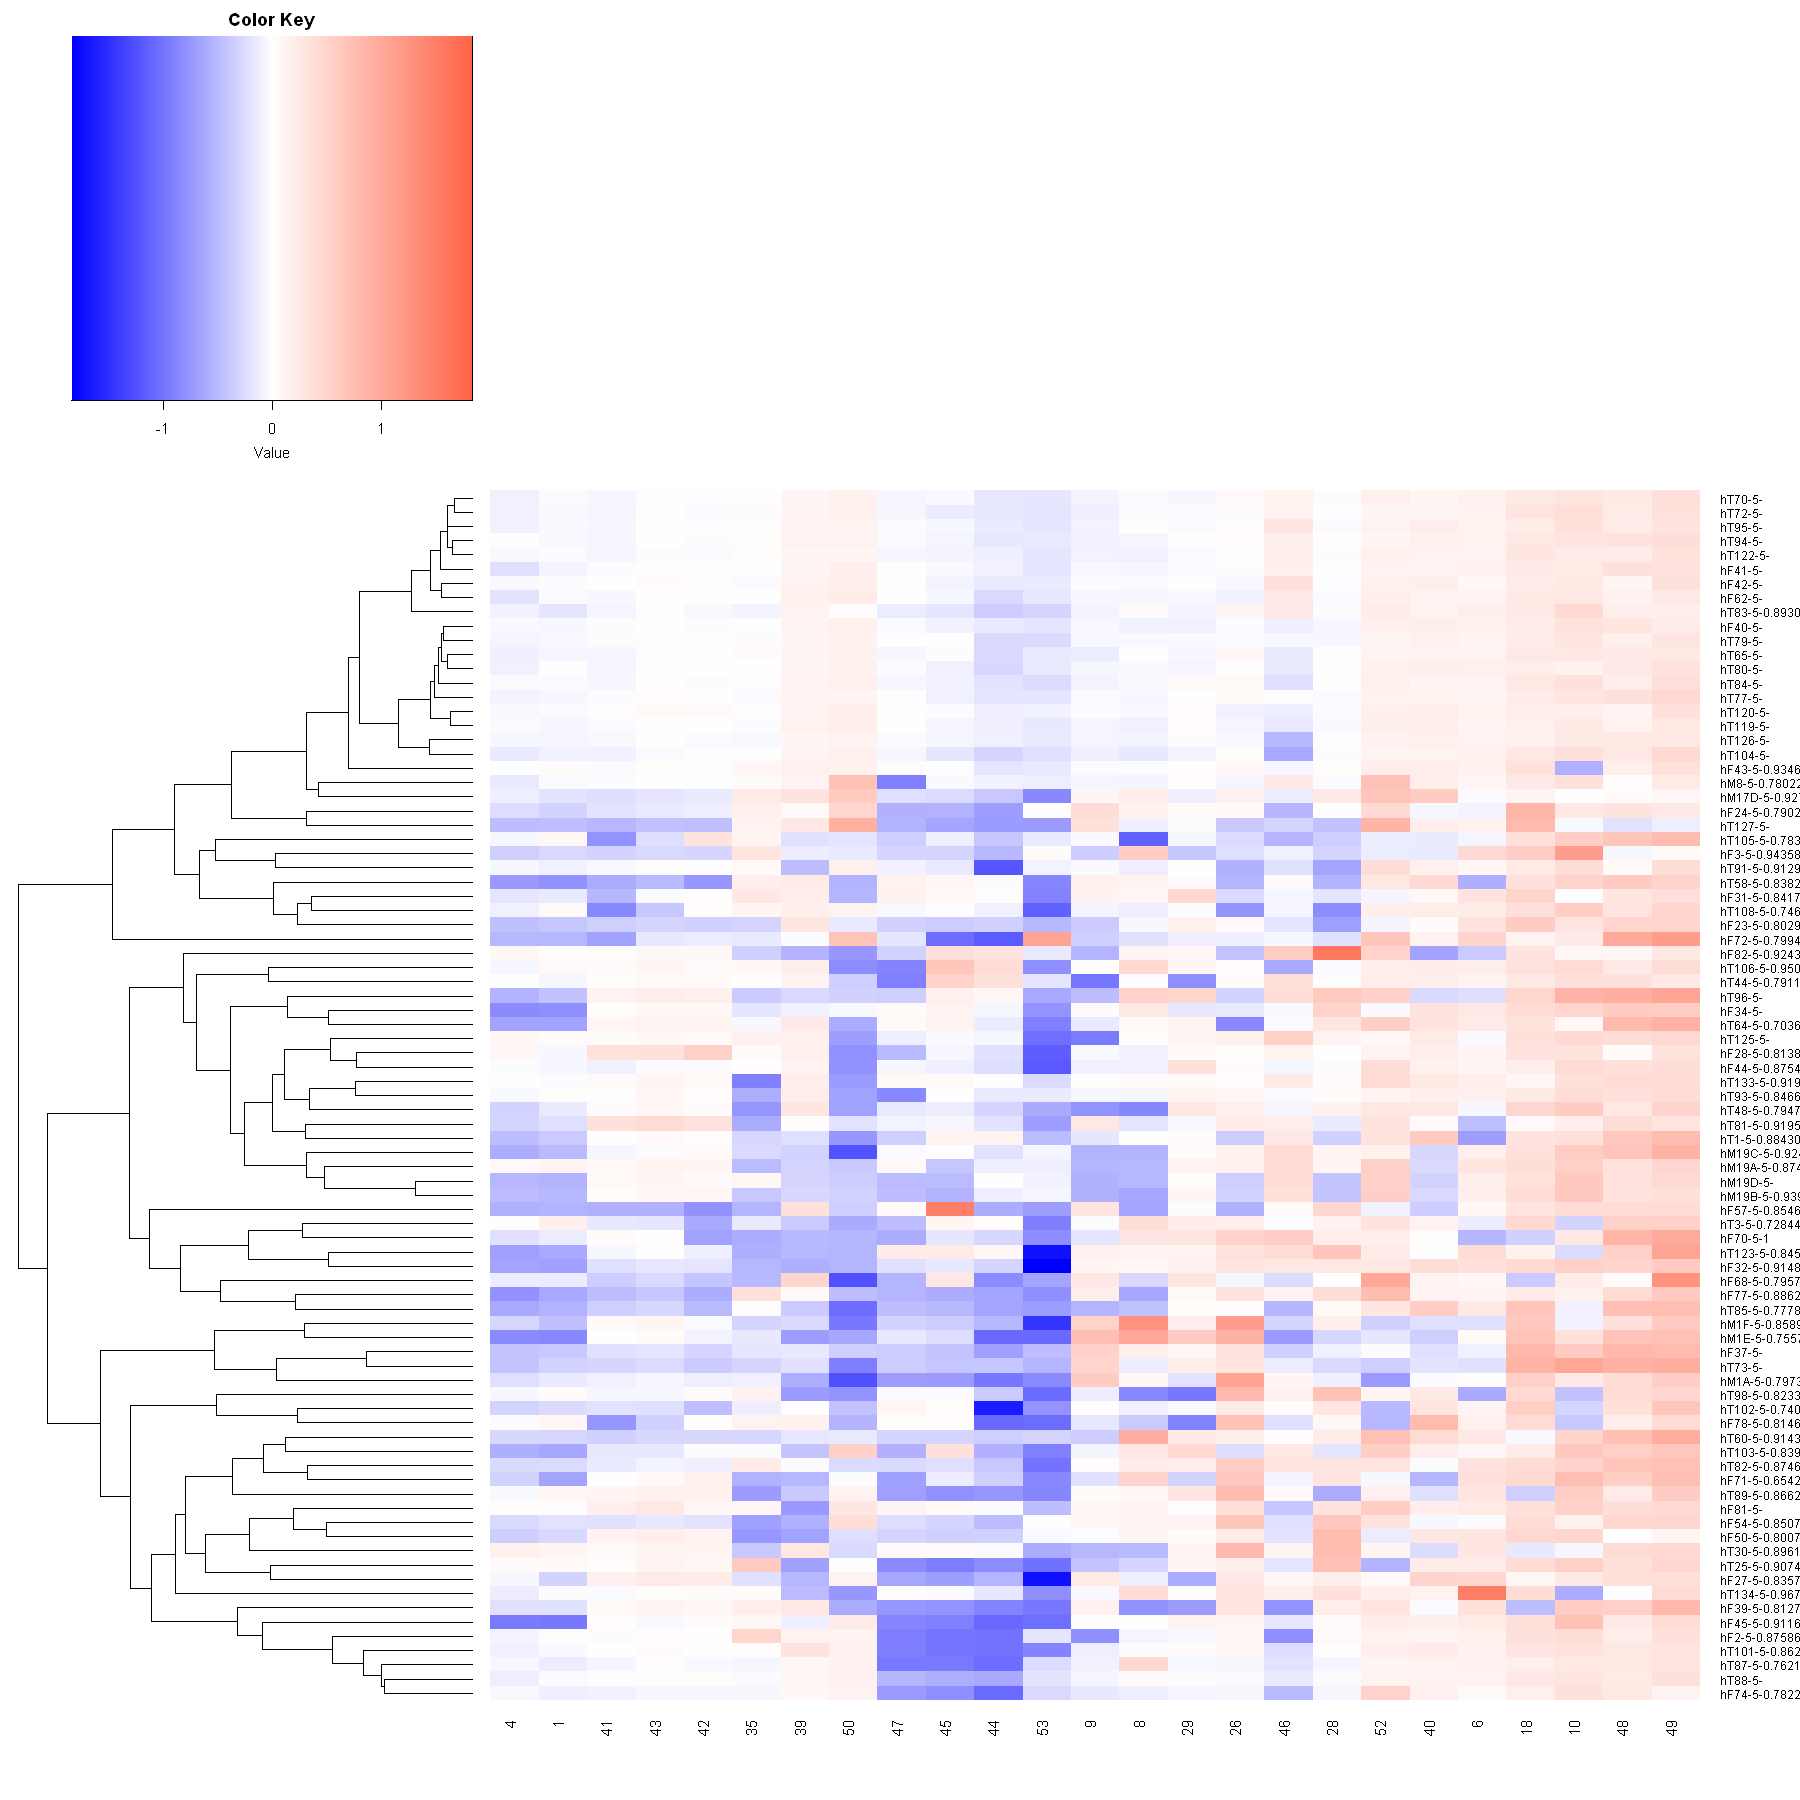

In [83]:
options(repr.plot.width=15, repr.plot.height=15)


for(label.i in seq(6)){
    labelData <- aucData[[label.i]]
    test_set <- cbind(training_set$melted)
    
    test_set$sampleId <- sapply(test_set$sampleId, 
                                function(sample){
                                    return(paste0(sample, "-", label.i, "-", labelData[labelData$SampleId == sample, ]$AUC))
                                })
    clusterTrainingSet(test_set, visualize = TRUE)
}



### Optionally, write training set matrix to file for supervised machine learning

In [ ]:
#setwd("~/Documents/Git-Projects/Git-Research-Projects/drug-response-prediction/mlOutput")
#write.csv(training_set$matrix, file ="coreTrainingSet_7_31_2018_1.csv")